\textbf{REDEME}:
1. This is an advanced version by combining more self-made primitive function in SR, which inherits from `DEAP CL Model 2D Class Inherit Version 1`. 
2. In this `jupyter notebook`, we are going to investigate the CL-SK, which could be found in Yamamoto's paper, though it is scaled with MPS. And the incident velocity is 1.9 MPS.
3. The CL-SK for tangential velocity is given by 
$$
R_{\mathrm{CLL, t}} = \frac{1}{\sqrt{\pi \sigma_t (2-\sigma_t)}} \times \mathrm{exp}\left\{-\frac{\left[V_{t, r}-(1-\sigma_t)V_{t, i}\right]^2}{\sigma_t(2-\sigma_t)}\right\} 
$$ where $\sigma_t$ is the thermal momentum accommodation coefficient (AC).
The CL-SK for normal velocity is given by
$$
R_{\mathrm{CLL, n}} = \frac{2 V_{n, r}}{\alpha_n} \times \mathrm{exp} \left\{-\frac{V_{n, r}^2+(1-\alpha_n)V_{n, i}^2}{ \alpha_n}\right\} \times I_0\left(\frac{2\sqrt{1-\alpha_n}V_{n, i}V_{n, r}}{\alpha_n}\right)
$$ where $\alpha_n$ is the AC of the normal kinetic energy.

4. Another point you need to keep in mind is that, all the data that are extracted from `SK_Data` folder should be scaled by MPS, i.e., velocity should divided by MPS and probability should be multiplied by MPS.
5. Actually, we got problems when fitting such data.

# Import Necessary Packages

In [27]:
import os

import time
import operator
import math
import random
import sympy
import multiprocessing
import numpy as np
import pandas as pd

# Plot the binary tree
import pygraphviz as pgv

import matplotlib.pyplot as plt
import scipy.special as special
from matplotlib.patches import Patch
from matplotlib import rcParams
from scipy.optimize import curve_fit
from scipy import integrate
from IPython.display import Image, display, Latex
from sklearn import metrics
from sklearn import model_selection

# from deap import algorithms
from deap import base
from deap import creator
from deap import tools
from deap import gp

In [28]:
import sys
sys.path.append("../")
from utils import createDataDic  # Self-mdae function stored in python file

In [29]:
cmap_data = plt.cm.Paired
cmap_cv = plt.cm.coolwarm
config = {
    "font.family":'Times New Roman',
    "font.size": 20,
    "mathtext.fontset":'stix',
    "axes.titlesize": 24
}
rcParams.update(config)


# Data Preprocessing
## Tangential Part
###  Getting all Dataset Path 
During this process, we use self-made function to create a dictionary to store paths of our data. The key is the parent folder name, then the child key is the file name without some nonsense postfix, lastly, the child value is the path for specific text file.

In [4]:
current_abs_path = os.path.abspath('.')  # Current absolute path
total_folder_name = '../SK_Data'
data_dic = createDataDic(current_abs_path,
                         total_folder_name)  # Data path dictionary
list(data_dic["Maxwellian"].keys())

E:\School 4\BEng Mechanical Engineering Project\AiFeynmanTest\CLL_Kernel\../SK_Data\.DS_Store is a file


['incident_velocity_normal',
 'incident_velocity_tangential',
 'incident_velocity_tangential_x',
 'incident_velocity_tangential_y',
 'normal_ACs',
 'README',
 'reflected_normal_01',
 'reflected_normal_05',
 'reflected_normal_09',
 'reflected_normal_14',
 'reflected_normal_19',
 'reflected_Tx_01',
 'reflected_Tx_05',
 'reflected_Tx_09',
 'reflected_Tx_14',
 'reflected_Tx_19',
 'reflected_velocity_normal',
 'reflected_velocity_tangential',
 'reflected_velocity_tangential_x',
 'reflected_velocity_tangential_y',
 'tangential_ACs',
 'tangential_KEs',
 'x_meas_gas_full']

In [5]:
def extracData(folder_name, file_name):
    """
    This is a function to extract the data in corresponding file.
    Variables:
        folder_name: The name of the child folder, e.g., it is diffusiveWall here.
        file_name: The name of the file for the specific velocity
    Returns:
        v: The velocity of this text file.
        number: The number of melocules with the same velocity, v.
        prob: The probability of the velocity, v. 
    Note: All the return values have been converted to numpy ndarray.
    """
    data_path = data_dic[folder_name][file_name]  # The path of the data
    data = pd.read_csv(data_path, header=None, sep=" ")
    data_np = np.array(
        data)  # convert the data from pandas' datafframe to numpy ndarray

    # Extract the data
    v = data_np[:, 0]
    number = data_np[:, 1]
    prob = data_np[:, 2]

    return v, number, prob


FOLDER_NAME = "Maxwellian"  # Second child folder name
FILE_LIST = [
    'incident_velocity_normal', 'incident_velocity_tangential',
    'incident_velocity_tangential_x', 'incident_velocity_tangential_y',
    'normal_ACs', 'README', 'reflected_normal_01', 'reflected_normal_05',
    'reflected_normal_09', 'reflected_normal_14', 'reflected_normal_19',
    'reflected_Tx_01', 'reflected_Tx_05', 'reflected_Tx_09', 'reflected_Tx_14',
    'reflected_Tx_19', 'reflected_velocity_normal',
    'reflected_velocity_tangential', 'reflected_velocity_tangential_x',
    'reflected_velocity_tangential_y', 'tangential_ACs', 'tangential_KEs',
    'x_meas_gas_full'
]  # The list contains all needed file name

### Visualize the data
1. Key information for constants of methane
- kB: the Boltmann constant, 
- Tw: the temperature of the wall, 
- mi: the molecular mass of methane.
2. In this section, we plot the all probabilities in terms of different velocity components, i.e., normal velocity, tangential velocity and its magnitude. At the same time, we used the most probable speed $v_m$ to scale our velocity, where $v_m = \sqrt{\frac{2 k_B T_w}{m_i}}$, so that we could gain non-dimension value here.
3. During analysis, we would like to use Equation \ref{eq: CL-SK tangential} to plot the theoretical value, where $V_{t, r}$ is the tangential velocity of reflected molecules, $V_{t, i}$ is the tangential velocity of incident particles and $V_{t, i} = 1.9 \times v_m$, and $\sigma_t = 0.3023$ 
$$
R_{\mathrm{CLL, n}} = \frac{2 V_{n, r}}{\alpha_n} \times \mathrm{exp} \left\{-\frac{V_{n, r}^2+(1-\alpha_n)V_{n, i}^2}{ \alpha_n}\right\} \times I_0\left(\frac{2\sqrt{1-\alpha_n}V_{n, i}V_{n, r}}{\alpha_n}\right)
\label{eq: CL-SK normal}
$$
which could be converted into analytical expression as follows, 
$$
R_{\mathrm{CLL, n}} = 4 V_{n, r} \mathrm{exp} \left\{-2 V_{n, r}^2-  V_{n, i}^2\right\} \times I_0\left(2.828 V_{n, i}V_{n, r}\right) = 4 V_{n, r} \mathrm{exp} \left\{-2 V_{n, r}^2- 0.81\right\} \times I_0\left(-2.546 V_{n, r}\right)
$$

-------------------- Parameter 1:4.441826899235795
-------------------- Parameter 2:-1.7094705815107927
-------------------- Parameter 3:-0.9602079606598054
-------------------- Parameter 4:2.1891808353405215


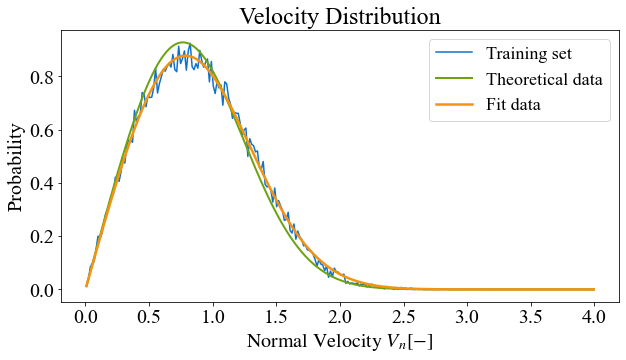

In [6]:
def calVm(parameters):
    """
    This is the function to calculate the most probable speed for methane. 
    Variables:
        Parameters: It is a dictionary that contains the properties of gas, the
            key is the name, value is the value of corresponding constant.
            kB: Boltzman const
            Tw: Temperature of the wall
            mi: Molecular mass fof methane
    Returns:
        Vm: The most probable speed.
        Vm0: Some times could be as reference, like Vm.
    """
    kB = parameters['kB']
    Tw = parameters['Tw']
    mi = parameters['mi']

    Vm = np.sqrt(2 * kB * Tw / mi)  # Most probable speed
    Vm0 = np.sqrt(kB * Tw / mi)  # reference velocity factor

    return Vm, Vm0


def theoDataTan(x):
    """
    This is the function to calculate the theoretical value of corresponding
    scattering kernel.
    ------------------
    Notice, we use global varibale CHO_NUM_TX here.
    Varibales:
        x: The velocity
        Cm: The most probable speed
    Returns:
        f: The theoretical value.
    """
    beta = sigmaT[CHO_NUM] * (2 - sigmaT[CHO_NUM])
    f = 1 / (np.sqrt(np.pi * beta)) * np.exp(
        -np.power(x - (1 - sigmaT[CHO_NUM]) * vincident[CHO_NUM], 2) / beta)

    return f


def theoDataNormal(x):
    """
    This is the function to calculate the theoretical value of corresponding
    scattering kernel.
    Varibales:
        x: The velocity
        Cm: The most probable speed
    Returns:
        f: The theoretical value.
    """
    alpha = np.complex(
        0, 2 * np.sqrt(1 - alphaN[CHO_NUM]) * vincident[CHO_NUM] /
        alphaN[CHO_NUM])

    beta = (1 - alphaN[CHO_NUM]) * np.square(
        vincident[CHO_NUM]) / alphaN[CHO_NUM]
    return 2 / alphaN[CHO_NUM] * x * np.exp(-np.power(x, 2) / alphaN[CHO_NUM] -
                                            beta) * special.jv(0,
                                                               alpha * x).real


def fitTan(x, A, B, C):
    return A * np.exp(-C * (x - B)**2)


def fitNormal(x, A, B, C, D):
    f1 = np.exp(B * x**2 + C)
    f2 = special.jv(0, np.complex(0, D) * x).real
    return A * x * f1 * f2


sigmaT = [0.3023, 0.2669, 0.2264, 0.1954,
          0.1515]  # All molecules - Partial TMAC
alphaN = [0.6139, 0.5666, 0.5000, 0.4439,
          0.4102]  # All molecules - Partial NKEAC
vincident = [0.1, 0.5, 0.9, 1.4,
             1.9]  # selected velocity magnitude (non-dimensionlised)
GAS_PROPERTIES = {
    'kB': 1.38064852e-23,
    'Tw': 423,
    'mi': 2.66389e-26
}  # The corresponding parameter of methane, kB is the Boltmann constant,
# Tw is the temperature of the wall, mi is the molecular mass of methane.

CHO_NUM = 2  # The chosen number in vincident, signmaT, alphaN list
key = "Normal"

if key == "Tangential":
    v, _, prob = extracData(FOLDER_NAME, FILE_LIST[11 + CHO_NUM])
    VM, _ = calVm(GAS_PROPERTIES)
    # Scale the data
    V = v / VM
    Y_TRAIN = prob * VM
    y_theo = theoDataTan(V)
    #     y_theo = 1 / integrate.simps(y_theo, V) * y_theo
    # Fit the data
    guess = [1, 0.5, 2.5]
    fit_para, _ = curve_fit(fitTan, V, Y_TRAIN, p0=guess)
    y_fit = fitTan(V, fit_para[0], fit_para[1], fit_para[2])
elif key == "Normal":
    v, _, prob = extracData(FOLDER_NAME, FILE_LIST[6 + CHO_NUM])
    VM, _ = calVm(GAS_PROPERTIES)
    # Scale the data
    V = v / VM
    Y_TRAIN = prob * VM
    y_theo = theoDataNormal(V)
    #     y_theo = 1 / integrate.simps(y_theo, V) * y_theo
    # Fit the data
    guess = [4, -2, -1, 2.546]
    fit_para, _ = curve_fit(fitNormal, V, Y_TRAIN, p0=guess)
    y_fit = fitNormal(V, fit_para[0], fit_para[1], fit_para[2], fit_para[3])

# Print fitting information
for i in range(4):
    print("{:-^20} Parameter ".format("") + str(i + 1) + ":" +
          str(fit_para[i]))

plt.figure(figsize=(10, 5))
plt.plot(V, Y_TRAIN, label="Training set", linewidth=1.5, c='#0e72cc')
plt.plot(V, y_theo, label='Theoretical data', linewidth=2, c='#6ca30f')
plt.plot(V, y_fit, label="Fit data", linewidth=2.5, c='#f59311')
if key == "Tangential":
    plt.xlabel("$\mathrm{Tangential\ Velocity}\ V_t [-]$")
elif key == "Normal":
    plt.xlabel("$\mathrm{Normal\ Velocity}\ V_n [-]$")

plt.ylabel("Probability")
plt.title("Velocity Distribution")
plt.legend(fontsize=18)

plt.show()

# DEAP Numpy
1. At the first stage, we use x_train and theo_y, i.e., the theoretical data without noise to test whether DEAP works for our idea. \textbf{NOTE}: The data structure is numpy.ndarray, which should be careful when creating corresponding  parts in DEAP. 
## DEAP SR Pipeline


In [7]:
# Tangential part
# A, B = V_TX.squeeze(), y_fit_tx.squeeze()#PROB_TX.squeeze()
VI = vincident[CHO_NUM]
vi_list = np.array([VI for _ in range(len(V))])
X_TRAIN = np.vstack((V, -vi_list)).T # 530 * 2 

In [8]:
"""Please note that, we change the definition of exponential function, which
could enhance the diversity of the model but also lead to no-solution problem."""

# Define new functions
def _protectedDiv(left, right):
    with np.errstate(divide='ignore', invalid='ignore'):
        x = np.divide(left, right)
        if isinstance(x, np.ndarray):
            x[np.isinf(x)] = 1
            x[np.isnan(x)] = 1
        elif np.isinf(x) or np.isnan(x):
            x = 1
    return x


def _protectedExp(x):
    """
    Clourse of exp for large result.
    """
    with np.errstate(divide='ignore', invalid='ignore', over='ignore'):
        exp_f = np.exp(x**2)
        return np.where(exp_f > 9e6, 0, exp_f)


def Bessel(x):
    try:
        alpha = np.array([np.complex(0, x_part) for x_part in x])
    except Exception as e:
        alpha = np.complex(0, x)
    return special.jv(0, alpha).real


def createPset(key):
    pset = gp.PrimitiveSet("MAIN", 2)
    pset.addPrimitive(np.add, 2, name="add")
    pset.addPrimitive(np.subtract, 2, name="sub")
    pset.addPrimitive(np.multiply, 2, name="mul")
    pset.addPrimitive(_protectedDiv, 2, name="div")
#     pset.addPrimitive(np.square, 1, name='square')
    pset.addPrimitive(_protectedExp, 1, name="exp")
#     pset.addPrimitive(np.negative, 1, name="neg")
    if key == "Normal":
        pset.addPrimitive(Bessel, 1, name="I0")

    pset.addEphemeralConstant(
        "rand_round", lambda: np.round_(random.uniform(0, 3), decimals=3))

    pset.renameArguments(ARG0='x')
    pset.renameArguments(ARG1='y')

    return pset

In [9]:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin)

In [23]:
def varAnd(population, toolbox, cxpb, mutpb):
    """Part of an evolutionary algorithm applying only the variation part
    (crossover **and** mutation). The modified individuals have their
    fitness invalidated. The individuals are cloned so returned population is
    independent of the input population.
    -------------------
    Variables: 
        :param population: A list of individuals to vary.
        :param toolbox: A :class:`~deap.base.Toolbox` that contains the 
                evolution operators.
        :param cxpb: The probability of mating two individuals. 
        :param mutpb: The probability of mutating an individual. This parameter 
                    should be a dictionary, so taht we could use multiple 
                    mutation mechanism. The key tis the muytation way, the value
                    is the mutation probability.
    ------------------
    :returns: A list of varied individuals that are independent of their
              parents.
    """
    offspring = [toolbox.clone(ind) for ind in population]

    # Apply crossover and mutation on the offspring
    for i in range(1, len(offspring), 2):
        if random.random() < cxpb["subtree"]:
            offspring[i - 1], offspring[i] = toolbox.mate(
                offspring[i - 1], offspring[i])
            del offspring[i - 1].fitness.values, offspring[i].fitness.values
        elif (random.random() >= cxpb["subtree"]) and (
                random.random() < cxpb["subtree"] + cxpb["leaf"]):
            offspring[i - 1], offspring[i] = toolbox.p_leaf_cx(
                offspring[i - 1], offspring[i])
            del offspring[i - 1].fitness.values, offspring[i].fitness.values

    prob_cx = cxpb["subtree"] + cxpb["leaf"]
    prob_middle = prob_cx + mutpb["full"]
    prob_last = prob_cx + mutpb["full"] + mutpb["grow"]
    for mut_name in list(mutpb.keys()):
        if mut_name == 'full':
            for i in range(len(offspring)):
                if (random.random() >= prob_cx) and (random.random() <
                                                     prob_middle):
                    offspring[i], = toolbox.mutate_full(offspring[i])
                    del offspring[i].fitness.values
        else:
            for i in range(len(offspring)):
                if (random.random() >= prob_middle) and (random.random() <
                                                         prob_last):
                    offspring[i], = toolbox.mutate_grow(offspring[i])
                    del offspring[i].fitness.values

    return offspring


def eaSimple(population,
             toolbox,
             cxpb,
             mutpb,
             ngen,
             stats=None,
             halloffame=None,
             verbose=__debug__):
    """This algorithm reproduce the simplest evolutionary algorithm as
    presented in chapter 7 of [Back2000]_.
    -----------------
    Variables:
        :param population: A list of individuals.
        :param toolbox: A :class:`~deap.base.Toolbox` that contains the evolution
                        operators.
        :param cxpb: The probability of mating two individuals.
        :param mutpb: The probability of mutating an individual. This parameter 
                    should be a dictionary, so taht we could use multiple
                    mutation mechanism. The key tis the muytation way, the 
                    value is the mutation probability.
        :param ngen: The number of generation.
        :param stats: A :class:`~deap.tools.Statistics` object that is updated
                      inplace, optional.
        :param halloffame: A :class:`~deap.tools.HallOfFame` object that will
                           contain the best individuals, optional.
        :param verbose: Whether or not to log the statistics.
    ----------------
    :returns: The final population
    :returns: A class:`~deap.tools.Logbook` with the statistics of the
              evolution
    """
    logbook = tools.Logbook()
    logbook.header = ['gen', 'nevals'] + (stats.fields if stats else [])

    # Evaluate the individuals with an invalid fitness
    invalid_ind = [ind for ind in population if not ind.fitness.valid]
    fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit

    if halloffame is not None:
        halloffame.update(population)

    record = stats.compile(population) if stats else {}
    logbook.record(gen=0, nevals=len(invalid_ind), **record)
    if verbose:
        print(logbook.stream)

    # Begin the generational process
    for gen in range(1, ngen + 1):
        # Select the next generation individuals
        offspring = toolbox.select(population, len(population))

        # Vary the pool of individuals
        offspring = varAnd(offspring, toolbox, cxpb, mutpb)

        # Evaluate the individuals with an invalid fitness
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit

        # Update the hall of fame with the generated individuals
        if halloffame is not None:
            halloffame.update(offspring)

        # Replace the current population by the offspring
        population[:] = offspring

        # Append the current generation statistics to the logbook
        record = stats.compile(population) if stats else {}
        logbook.record(gen=gen, nevals=len(invalid_ind), **record)
        if verbose:
            print(logbook.stream)

        # Set stopping criteria
        if record['fitness']['min'] < 0.0001:
            print('The stopping criteria is met, with fitness {}'.format(
                record['fitness']['min']))
            break

    return population, logbook, record

In [15]:
class BaseSymReg():
    """creator has been treated as global one.
    --------------------------------
    Variables:
        _Data_info: Dictionary
            It should be the structure like the following example, 
            Data_info = {
                "X_train": X_TX,  # training  X, m*2, where m is number of sampling points.
                "y_train": PROB_TX,  # training y
                "fit": y_fit_normal,  # fit data, but for empirical data, it could be None
                "fit_para": fit_parameters_normal,  # same as before
                "theoretical": y_theo_normal,  # theoretical data, should be None for real
            }
            Here it contains the X, y we want to fit in our job. 
        _mutation_dic: Dictionary
            It should be the structure like *mutation_dic = {'full': 0.05, 'grow': 0.1}*.
            Since we only include two mutation tree generation ways, i.e., full
            and grow, the mutation probability should noly be the configuration
            like this.
        _pset: `gplean.gp.PrimitiveSet`
            It is a primitive set containing all the functions, variables and
            constant.
        save_path: string
            It is a path to save the comparison figure.
        _generation: int, default as 20
            The generation number.
        _penelty_coeff: list, default as [0, 0.001, 0.001]
            It is the coefficient before our L2 regularization, i.e., integration
            penalty.
        _height_max_value: int, default as 4
            It controls bloat problem in SR. The value here means the maximum
            length of the deepest tree.
        _pop_size: int, default as 2000
            The population size.
        _prob_cx_subtree: float, default as 0.5.
            Crossover action.
        _prob_cx_leaf: float, default as 0.1.
            Crossover action, but not the whole subtree.
        sk_kind: string
            There are two kinds of skcattering kernels, i.e. normal and
            tangential. In this class, we only accept `Normal` and `Tangential` 
            as our key word to do some analysis.
    -------------------
    NOTE: There are two global variable in this class, i.e., A and B. 
        A is the X_train, B is the y_trian or any other knid of y value.
    """
    def __init__(self,
                 Data_info,
                 mutation_dic,
                 pset,
                 save_path,
                 generation=20,
                 population_size=2000,
                 height_max_value=4,
                 prob_cx_subtree=0.5,
                 prob_cx_leaf=0.1,
                 sk_kind="Normal",
                 penalty_coeff=[0, 0.001, 0.001]):
        self._Data_info = Data_info
        self._mutation_dic = mutation_dic
        self._pset = pset
        self.save_path = save_path
        self._generation = generation
        self._height_max_value = height_max_value
        self._pop_size = population_size
        self._prob_cx_subtree = prob_cx_subtree
        self._prob_cx_leaf = prob_cx_leaf
        self.sk_kind = sk_kind
        self._penelty_coeff = penalty_coeff

    def __del__(self):
        """We need to delete the instance to release the memory."""
        print("The instance has been deleted")

    def assembleGP(self, ):
        toolbox = base.Toolbox()

        toolbox.register("expr",
                         gp.genHalfAndHalf,
                         pset=self._pset,
                         min_=1,
                         max_=6)
        toolbox.register("individual", tools.initIterate, creator.Individual,
                         toolbox.expr)
        toolbox.register("population", tools.initRepeat, list,
                         toolbox.individual)
        toolbox.register("compile", gp.compile, pset=self._pset)

        def evalSymbReg(individual, points, y_true):
            """At this function, we must consider so many exceptions for
            integration.
            ---------
                Points: m*2, m is the number of sampling points.
            """
            m, _ = points.shape
            # Transform the tree expression in a callable function
            func = toolbox.compile(expr=individual)
            # Evaluate the mean squared error between the expression
            y_pred = func(points[:, 0], points[:, 1])
            numerator = np.sum((y_true - y_pred)**2)
            error = np.sqrt(numerator) / m # MSE
#             denominator = np.sum((y_true - np.average(y_true))**2)
#             error = np.sqrt(numerator / denominator) / m
            # Probability should be larger than zero

            if np.array(y_pred < 0.0).any():
                P_1 = np.average(np.abs(y_pred[y_pred < 0.0]))
            else:
                P_1 = 0.0

            # Integration constraint
            try:
                """Sometimes the function could be a number."""
                inte = integrate.simps(y_pred, points[:, 0])
            except Exception as e:
                inte = y_pred * (np.max(points[:, 0]) - np.min(points[:, 0]))
            finally:
                with np.errstate(over='ignore'):
                    # P_2 = (inte - 1)**2
                    P_2 = np.abs(inte-1)
            # Detailed balance
            if self.sk_kind == "Tangential":
                left = np.exp(-points[:, 1]**2) * func(points[:, 0], points[:,
                                                                            1])
                right = np.exp(-points[:, 0]**2) * func(
                    -points[:, 1], -points[:, 0])
                P_3 = np.sqrt(np.sum((left-right)**2))
#                 P_3 = np.sqrt(np.average((left - right)**2))
#                 P_3 = np.average(np.abs(left - right))
            elif self.sk_kind == "Normal":
                left = np.abs(points[:, 1]) * np.exp(-points[:, 1]**2) * func(
                    points[:, 0], points[:, 1])
                right = points[:, 0] * np.exp(-points[:, 0]**2) * func(
                    -points[:, 1], -points[:, 0])
                with np.errstate(over='ignore'):
                    P_3 = np.sqrt(np.sum((left-right)**2))
#                     P_3 = np.sqrt(np.average((left-right)**2))
#                     P_3 = np.average((left - right)**2)
            else:
                raise ("Please Input Valid SKs Type during Creating Instance!")
            errors = error + self._penelty_coeff[0] * P_1 + self._penelty_coeff[
                1] * P_2 + self._penelty_coeff[2] * P_3

            return errors,

        # Fitness function
        toolbox.register("evaluate",
                         evalSymbReg,
                         points=self._Data_info["X_train"],
                         y_true=self._Data_info["y_train"])
        # Selection
        toolbox.register("select", tools.selTournament, tournsize=20)
        # Crossover
        toolbox.register("mate", gp.cxOnePoint)  # Subtree crossover
        toolbox.register("p_leaf_cx",
                         gp.cxOnePointLeafBiased,
                         termpb=self._prob_cx_leaf)  # leaf crossover
        # Mutation
        toolbox.register("expr_mut_full", gp.genFull, min_=0,
                         max_=3)  # The depth of leaf are strict constrainted
        toolbox.register("expr_mut_grow", gp.genGrow, min_=0,
                         max_=5)  # The depth is varying
        toolbox.register("mutate_full",
                         gp.mutUniform,
                         expr=toolbox.expr_mut_full,
                         pset=self._pset)
        toolbox.register("mutate_grow",
                         gp.mutUniform,
                         expr=toolbox.expr_mut_grow,
                         pset=self._pset)

        # Bloat control: It is useful for crossover and mutation
        toolbox.decorate(
            "mate",
            gp.staticLimit(key=operator.attrgetter("height"),
                           max_value=self._height_max_value))
        toolbox.decorate(
            "mutate_full",
            gp.staticLimit(key=operator.attrgetter("height"),
                           max_value=self._height_max_value))
        toolbox.decorate(
            "mutate_grow",
            gp.staticLimit(key=operator.attrgetter("height"),
                           max_value=self._height_max_value))
        toolbox.decorate(
            "p_leaf_cx",
            gp.staticLimit(key=operator.attrgetter("height"),
                           max_value=self._height_max_value))

        return toolbox

    def score(self, X, y, best_tree):
        """This is a test function to give R^2 value as the score, where
        R^2 = (1 - U/V), which means R^2 is higher when the model's performance
        is better.
        """ 
        func = gp.compile(str(best_tree), pset=self._pset)
        y_pred = func(X[:, 0], X[:, 1])
        
        return np.sqrt(np.sum((y - y_pred)**2) / (y_pred.shape[0] - 2))

    def main_program(self):
        random.seed(0)

        # 1. Prepare toolbox
        toolbox = self.assembleGP()

        # 2. Getting population
        pop = toolbox.population(n=self._pop_size)
        hof = tools.HallOfFame(1)

        # 3. Prepare log information
        stats_fit = tools.Statistics(lambda ind: ind.fitness.values)
        stats_size = tools.Statistics(len)
        mstats = tools.MultiStatistics(fitness=stats_fit, size=stats_size)
        mstats.register("min", np.min)

        # 4. Evolution
        pop, log, record = eaSimple(
            pop,
            toolbox,
            cxpb={"subtree":self._prob_cx_subtree, "leaf":self._prob_cx_leaf},
            mutpb=self._mutation_dic,
            ngen=self._generation,
            stats=mstats,
            halloffame=hof,
            verbose=True
        )  # record gives the minimum fitness of each generation

        return pop, log, hof, record

    def _timeTransfer(self, total_time):
        """Transfer time into minutes and seconds"""
        minute = total_time // 60
        second = total_time % 60

        return minute, second

    def treeTransfer(self, hof):
        """
        Transfer the optimal individual into symbolc expression using string
        format.
        ----------------------
        hof_tree_expr: It is a simplified symbolic mathematical expression.
        hof_tree: It is a gp.PrimitiveTree structure, which is not a string
            that could be compiled to a function using gp.compile. Thus you need
            to use str(hof_tree) so that you could compile it.
        """
        converter = {
            'sub': lambda x, y: x - y,
            'div': lambda x, y: x / y,
            'mul': lambda x, y: x * y,
            'add': lambda x, y: x + y,
            'neg': lambda x: -x,
            'abs': lambda x: sympy.Abs(x),
            'pow': lambda x, y: x**y,
            'sin': lambda x: sympy.sin(x),
            'cos': lambda x: sympy.cos(x),
            'inv': lambda x: 1 / x,
            'sqrt': lambda x: x**0.5,
            'exp': lambda x: sympy.exp(x**2),
            'square': lambda x: x**2
        }  # Converter set

        hof_tree = gp.PrimitiveTree(hof)[0]
        hof_tree_str = str(gp.PrimitiveTree(hof)[0])
        hof_tree_expr = sympy.sympify(hof_tree_str, locals=converter)
        hof_tree_expr = sympy.simplify(
            hof_tree_expr)  # simplify the expression

        return hof_tree_expr, hof_tree

    def plotComparison(self, best_tree):
        """
        best_tree: It shoule be PrimitiveTree structure, which should be
            converted into str here, so that the compilation could be made.
        """

        X = self._Data_info["X_train"]
        x_1, x_2 = X[:, 0], X[:, 1]
        noised_y = self._Data_info["y_train"]
        best_func = gp.compile(str(best_tree), self._pset)
        best_y = np.array(best_func(x_1, x_2))
        try:
            best_y.shape[0]
        except:
            best_y = [best_y for _ in range(x_1.shape[0])]
 
        theo_y = self._Data_info["theoretical"]

        fig = plt.figure(figsize=(9, 6))
    
        plt.plot(x_1, noised_y, label='Training set', linewidth=1.5, c='#0e72cc')
        plt.plot(x_1, theo_y, label="Theoretical data", linewidth=2, c='#6ca30f')
        plt.plot(x_1, best_y, label="Symbolic Data", c='#f59311')
        if self.sk_kind == "Normal":
            plt.xlabel('$\mathrm{Normal\ Velocity}\ V_n[-]$')
        elif self.sk_kind == "Tangential":
            plt.xlabel('$\mathrm{Tangential\ Velocity}\ V_t[-]$')
        else:
            plt.xlabel("$\mathrm{Velocity}\ V[-]$")

        plt.ylabel('Probability')
        plt.title('Velocity Distribution')
        plt.legend(fontsize=18, loc=0)

        plt.savefig(self.save_path)
        plt.show()

        theo_r2 = self.score(X, theo_y, best_tree)
        print("Theoretical SEOE = {:.3f}".format(theo_r2))
        training_r2 = self.score(X, noised_y, best_tree)
        print("Training SEOE = {:.3f}".format(training_r2))

    def treePlot(self, best_tree, path):
        nodes, edges, labels = gp.graph(best_tree)
        g = pgv.AGraph(ranksep="0.3", directed=True, strict=True)
        g.add_nodes_from(nodes)
        g.add_edges_from(edges)
        g.layout(prog="dot")

        for i in nodes:
            node = g.get_node(i)
            # node.attr["label"] = labels[i]
            if isinstance(labels[i], float) or isinstance(labels[i], int):
                node.attr["label"] = np.round_(labels[i], decimals=3)
                node.attr['color'] = 'blue'
            else:
                node.attr["label"] = labels[i]
                if len(labels[i]) > 1:
                    node.attr['color'] = 'red'
                else:
                    node.attr['color'] = 'blue'

        g.draw(path)
        display(Image(path, height=150))
 

In [12]:
pset = createPset(key)

In [13]:
"""Here, we changed the height_max_value to 5 instead of 4, so the bloat control 
is changed."""

class AdvancedSR(BaseSymReg):
    def __init__(self, Data_info, mutation_dic, pset, fig_path, tree_path,
            gene_size=3, pop_size = 5000, prob_cx_subtree=0.5, sk_kind="Tangential",
            penalty_list=[0, 0.04, 0.2]):
        super().__init__(Data_info, mutation_dic, pset, fig_path, population_size=2000,
            generation=gene_size, prob_cx_subtree=prob_cx_subtree, sk_kind=sk_kind,
            penalty_coeff=penalty_list, height_max_value=5)
        self.tree_path = tree_path
        self._pset = pset
        
    def leftHand(self, function, V):
        if self.sk_kind == "Tangential":
            return np.exp(-V[:, 1]**2) * function(V[:, 0], V[:, 1])
        else:
            return np.abs(V[:, 1])*np.exp(-V[:, 1]**2)*function(V[:, 0], V[:, 1])

    def rightHand(self, function, V):
        if self.sk_kind == "Tangential":
            return np.exp(-V[:, 0]**2) * function(-V[:, 1], -V[:, 0])
        else:
            return V[:, 0] * np.exp(-V[:, 0]**2) * (function(-V[:, 1], -V[:, 0]))
    
    def mainRun(self):
        # Time counting starts
        time_start = time.time()
        
        # 1. Run evolutionary program
        pop, log, hof, record = BaseSymReg.main_program(self)
        # 2. Obtain the best 
        best_sr_expr, best_tree = BaseSymReg.treeTransfer(self, hof)
        # 3. Plot the data
        BaseSymReg.plotComparison(self, best_tree)
        # 4. Display the expression
        display(best_sr_expr)  
        # 5. Plot the tree structure
        BaseSymReg.treePlot(self, best_tree, self.tree_path)
        
        # Time ending 
        time_end = time.time()
        total_time = time_end - time_start
        print("Total Time: {:.3f} s".format(total_time))

        return best_tree
    
    def reciprocityCon(self, best_tree):
        if self.sk_kind == "Tangential":
            vi = vincident[CHO_NUM]
            func = gp.compile(str(best_tree), pset=self._pset)
            a = np.linspace(-4, 4, num=100)
            b = np.array([vi for i in range(len(a))])
            train_x = np.vstack((a, -b)).T
        else:
            vi = vincident[CHO_NUM]
            func = gp.compile(str(best_tree), pset=pset)
            a_n = np.linspace(0.007, 4, num=100)
            b_n = np.array([vi for i in range(len(a_n))])
            train_x = np.vstack((a_n, -b_n)).T

        lefthand = self.leftHand(func, train_x)
        righthand = self.rightHand(func, train_x)

        fig = plt.figure(figsize=(9, 6))
        plt.plot(train_x[:, 0], lefthand, label="left hand", c='red')
        plt.scatter(train_x[:, 0], righthand, label="right hand")
        plt.ylabel("Probability")
        plt.title("Reciprocity Relation")
        if self.sk_kind == "Tangential":
            plt.xlabel("$\mathrm{Tangential\ Velocity}\ V_t [-]$")
#             plt.savefig("./DEPA CL tangential detailed balance")
        else:
            plt.xlabel("$\mathrm{Normal\ Velocity}\ V_n [-]$")
#             plt.savefig("./DEPA CL normal detailed balance")
        plt.legend(fontsize=18)
        plt.show()
    

In [16]:
def calculateFitness(best_tree):
    m, _ = X_TRAIN.shape
    # Transform the tree expression in a callable function
    func = gp.compile(str(best_tree), pset)
    # Evaluate the mean squared error between the expression
    y_pred = func(X_TRAIN[:, 0], X_TRAIN[:, 1])
    numerator = np.sum((y_fit - y_pred)**2)
    error = np.sqrt(numerator) / m 
#     denominator = np.sum((PROB_NORMAL - np.average(PROB_NORMAL))**2)
#     error = np.sqrt(numerator / denominator) / m
    # Probability should be larger than zero

    if np.array(y_pred < 0.0).any():
        P_1 = np.average(np.abs(y_pred[y_pred < 0.0]))
    else:
        P_1 = 0.0

    # Integration constraint
    try:
        """Sometimes the function could be a number."""
        inte = integrate.simps(y_pred, X_TRAIN[:, 0])
    except Exception as e:
        inte = y_pred * (np.max(X_TRAIN[:, 0]) - np.min(X_TRAIN[:, 0]))
    finally:
        with np.errstate(over='ignore'):
            # P_2 = (inte - 1)**2
            P_2 = np.abs(inte - 1)
    # Detailed balance
    if key == "Tangential":
        left = np.exp(-X_TRAIN[:, 1]**2) * func(X_TRAIN[:, 0], X_TRAIN[:, 1])
        right = np.exp(-X_TRAIN[:, 0]**2) * func(-X_TRAIN[:, 1], -X_TRAIN[:, 0])
        P_3 = np.sqrt(np.sum((left-right)**2))
    elif key == "Normal":
        left = np.abs(X_TRAIN[:, 1]) * np.exp(-X_TRAIN[:, 1]**2) * func(
            X_TRAIN[:, 0], X_TRAIN[:, 1])
        right = X_TRAIN[:, 0] * np.exp(-X_TRAIN[:, 0]**2) * func(
            -X_TRAIN[:, 1], -X_TRAIN[:, 0])
        with np.errstate(over='ignore'):
            P_3 = np.sqrt(np.sum((left-right)**2))
    print(
        "Fitness information: ---------- \n Error: {:<20} \n P_1: {:<20} \n P_2: {:<20} \n P_3: {:<20}"
        .format(error, P_1, P_2, P_3))

--------------------------------------0.5---------------------------------------


<ipython-input-11-a6497ed68dc1>:136: RuntimeWarning: invalid value encountered in subtract
  P_3 = np.sqrt(np.sum((left-right)**2))
<ipython-input-11-a6497ed68dc1>:100: RuntimeWarning: overflow encountered in square
  numerator = np.sum((y_true - y_pred)**2)
<ipython-input-11-a6497ed68dc1>:141: RuntimeWarning: invalid value encountered in double_scalars
  errors = error + self._penelty_coeff[0] * P_1 + self._penelty_coeff[


   	      	       fitness        	         size         
   	      	----------------------	----------------------
gen	nevals	gen	min	nevals	gen	min	nevals
0  	2000  	0  	nan	2000  	0  	2  	2000  
1  	1635  	1  	nan	1635  	1  	1  	1635  
2  	1649  	2  	nan	1649  	2  	1  	1649  
3  	1608  	3  	nan	1608  	3  	1  	1608  
4  	1659  	4  	nan	1659  	4  	1  	1659  
5  	1669  	5  	nan	1669  	5  	1  	1669  
6  	1660  	6  	nan	1660  	6  	1  	1660  
7  	1650  	7  	nan	1650  	7  	1  	1650  
8  	1663  	8  	nan	1663  	8  	1  	1663  
9  	1634  	9  	nan	1634  	9  	1  	1634  
10 	1659  	10 	nan	1659  	10 	1  	1659  
11 	1625  	11 	nan	1625  	11 	1  	1625  
12 	1644  	12 	nan	1644  	12 	1  	1644  
13 	1682  	13 	nan	1682  	13 	1  	1682  
14 	1595  	14 	nan	1595  	14 	1  	1595  
15 	1675  	15 	nan	1675  	15 	1  	1675  
16 	1639  	16 	nan	1639  	16 	1  	1639  
17 	1637  	17 	nan	1637  	17 	1  	1637  
18 	1658  	18 	nan	1658  	18 	1  	1658  
19 	1670  	19 	nan	1670  	19 	1  	1670  
20 	1642  	20 	nan	1642  

177	1630  	177	nan        	1630  	177	1  	1630  
178	1633  	178	0.000558706	1633  	178	1  	1633  
179	1640  	179	nan        	1640  	179	1  	1640  
180	1659  	180	0.000558706	1659  	180	1  	1659  
181	1641  	181	nan        	1641  	181	1  	1641  
182	1696  	182	nan        	1696  	182	1  	1696  
183	1648  	183	nan        	1648  	183	1  	1648  
184	1682  	184	nan        	1682  	184	1  	1682  
185	1699  	185	nan        	1699  	185	1  	1699  
186	1665  	186	nan        	1665  	186	1  	1665  
187	1635  	187	nan        	1635  	187	1  	1635  
188	1664  	188	nan        	1664  	188	1  	1664  
189	1673  	189	nan        	1673  	189	1  	1673  
190	1655  	190	nan        	1655  	190	1  	1655  
191	1633  	191	nan        	1633  	191	1  	1633  
192	1648  	192	nan        	1648  	192	1  	1648  
193	1650  	193	nan        	1650  	193	1  	1650  
194	1639  	194	nan        	1639  	194	1  	1639  
195	1657  	195	nan        	1657  	195	1  	1657  
196	1654  	196	nan        	1654  	196	1  	1654  
197	1638  	197	nan  

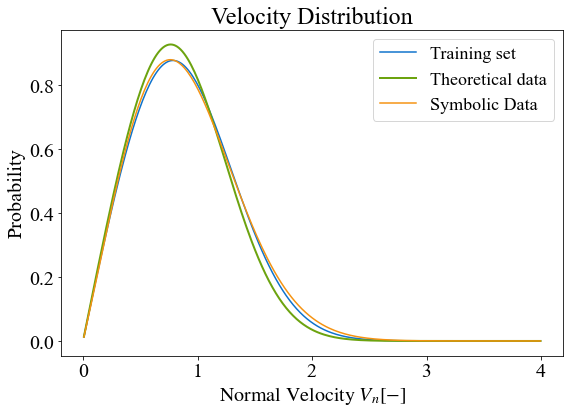

Theoretical SEOE = 0.029
Training SEOE = 0.009


2.18615286269239*x*exp(-x**2)/I0(x*y + 1.166555)

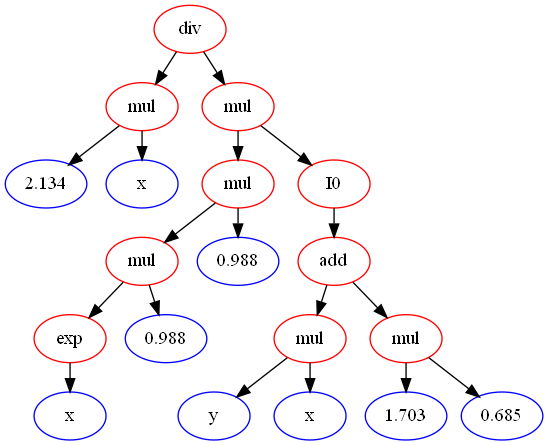

Total Time: 182.819 s


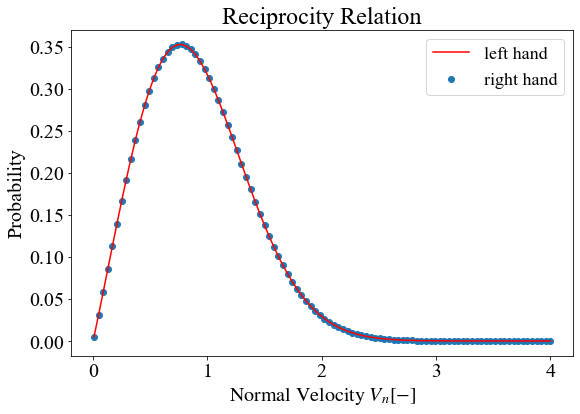

Fitness information: ---------- 
 Error: 0.000552034048097944 
 P_1: 0.0                  
 P_2: 0.01693731344563676  
 P_3: 4.078481422822891e-16
--------------------------------------0.1---------------------------------------


<string>:1: RuntimeWarning: invalid value encountered in multiply
<ipython-input-11-a6497ed68dc1>:136: RuntimeWarning: invalid value encountered in subtract
  P_3 = np.sqrt(np.sum((left-right)**2))
<ipython-input-11-a6497ed68dc1>:100: RuntimeWarning: overflow encountered in square
  numerator = np.sum((y_true - y_pred)**2)
<ipython-input-11-a6497ed68dc1>:141: RuntimeWarning: invalid value encountered in double_scalars
  errors = error + self._penelty_coeff[0] * P_1 + self._penelty_coeff[
D:\SoftwareAPPs\Anaconda\AnacondaInstaller\lib\site-packages\scipy\integrate\_quadrature.py:398: RuntimeWarning: invalid value encountered in add
  tmp = hsum/6.0 * (y[slice0]*(2-1.0/h0divh1) +
D:\SoftwareAPPs\Anaconda\AnacondaInstaller\lib\site-packages\numpy\core\fromnumeric.py:87: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
<string>:1: RuntimeWarning: invalid value encountered in subtract
<string>:1: RuntimeWarning: invalid value enc

   	      	       fitness        	         size         
   	      	----------------------	----------------------
gen	nevals	gen	min	nevals	gen	min	nevals
0  	2000  	0  	nan	2000  	0  	2  	2000  
1  	1640  	1  	nan	1640  	1  	1  	1640  
2  	1637  	2  	nan	1637  	2  	1  	1637  
3  	1656  	3  	nan	1656  	3  	1  	1656  
4  	1663  	4  	nan	1663  	4  	1  	1663  
5  	1666  	5  	nan	1666  	5  	1  	1666  
6  	1651  	6  	nan	1651  	6  	1  	1651  
7  	1661  	7  	nan	1661  	7  	1  	1661  
8  	1655  	8  	nan	1655  	8  	1  	1655  
9  	1672  	9  	nan	1672  	9  	1  	1672  
The instance has been deleted
10 	1645  	10 	nan	1645  	10 	1  	1645  
11 	1634  	11 	nan	1634  	11 	1  	1634  
12 	1660  	12 	nan	1660  	12 	1  	1660  
13 	1656  	13 	nan	1656  	13 	1  	1656  
14 	1649  	14 	nan	1649  	14 	1  	1649  
15 	1655  	15 	nan	1655  	15 	1  	1655  
16 	1640  	16 	nan	1640  	16 	1  	1640  
17 	1676  	17 	nan	1676  	17 	1  	1676  
18 	1659  	18 	nan	1659  	18 	1  	1659  
19 	1664  	19 	nan	1664  	19 	1  	16

176	1652  	176	nan       	1652  	176	1  	1652  
177	1630  	177	nan       	1630  	177	1  	1630  
178	1658  	178	nan       	1658  	178	1  	1658  
179	1603  	179	nan       	1603  	179	1  	1603  
180	1625  	180	nan       	1625  	180	1  	1625  
181	1648  	181	nan       	1648  	181	1  	1648  
182	1665  	182	0.00141746	1665  	182	1  	1665  
183	1669  	183	0.00141746	1669  	183	1  	1669  
184	1660  	184	nan       	1660  	184	1  	1660  
185	1644  	185	nan       	1644  	185	1  	1644  
186	1650  	186	nan       	1650  	186	1  	1650  
187	1625  	187	nan       	1625  	187	1  	1625  
188	1631  	188	nan       	1631  	188	1  	1631  
189	1653  	189	nan       	1653  	189	1  	1653  
190	1681  	190	nan       	1681  	190	1  	1681  
191	1650  	191	nan       	1650  	191	1  	1650  
192	1656  	192	nan       	1656  	192	1  	1656  
193	1679  	193	nan       	1679  	193	1  	1679  
194	1656  	194	nan       	1656  	194	1  	1656  
195	1643  	195	nan       	1643  	195	1  	1643  
196	1635  	196	nan       	1635  	196	1  

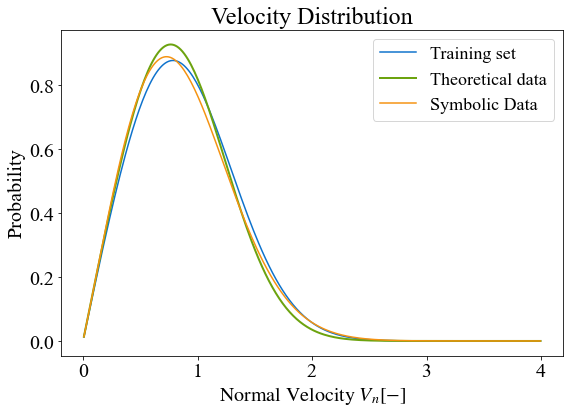

Theoretical SEOE = 0.020
Training SEOE = 0.023


2.09205020920502*x*exp(-x**2)/I0(x + y)

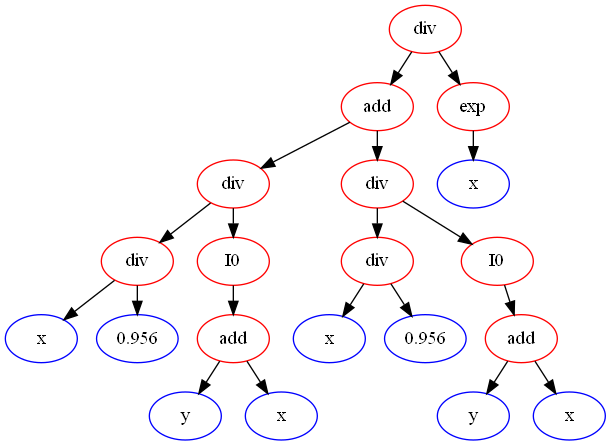

Total Time: 383.968 s


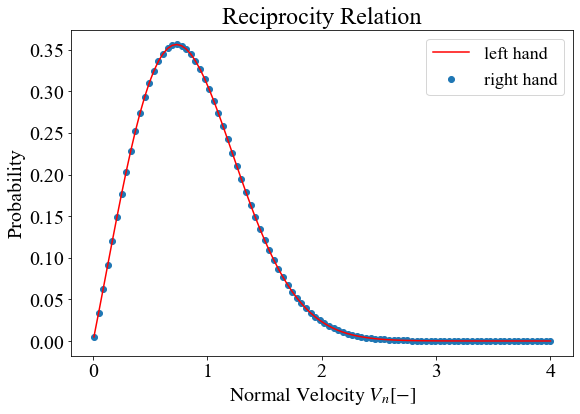

Fitness information: ---------- 
 Error: 0.0014174602954444271 
 P_1: 0.0                  
 P_2: 0.00432201958856171  
 P_3: 3.5910314675249486e-16
--------------------------------------0.05--------------------------------------


<string>:1: RuntimeWarning: invalid value encountered in multiply
<ipython-input-11-a6497ed68dc1>:136: RuntimeWarning: invalid value encountered in subtract
  P_3 = np.sqrt(np.sum((left-right)**2))
<ipython-input-11-a6497ed68dc1>:100: RuntimeWarning: overflow encountered in square
  numerator = np.sum((y_true - y_pred)**2)
<ipython-input-11-a6497ed68dc1>:141: RuntimeWarning: invalid value encountered in double_scalars
  errors = error + self._penelty_coeff[0] * P_1 + self._penelty_coeff[
D:\SoftwareAPPs\Anaconda\AnacondaInstaller\lib\site-packages\scipy\integrate\_quadrature.py:398: RuntimeWarning: invalid value encountered in add
  tmp = hsum/6.0 * (y[slice0]*(2-1.0/h0divh1) +
D:\SoftwareAPPs\Anaconda\AnacondaInstaller\lib\site-packages\numpy\core\fromnumeric.py:87: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
<string>:1: RuntimeWarning: invalid value encountered in subtract
<string>:1: RuntimeWarning: invalid value enc

   	      	       fitness        	         size         
   	      	----------------------	----------------------
gen	nevals	gen	min	nevals	gen	min	nevals
0  	2000  	0  	nan	2000  	0  	2  	2000  
1  	1639  	1  	nan	1639  	1  	1  	1639  
2  	1619  	2  	nan	1619  	2  	1  	1619  
3  	1639  	3  	nan	1639  	3  	1  	1639  
4  	1672  	4  	nan	1672  	4  	1  	1672  
5  	1662  	5  	nan	1662  	5  	1  	1662  
6  	1651  	6  	nan	1651  	6  	1  	1651  
7  	1657  	7  	nan	1657  	7  	1  	1657  
8  	1631  	8  	nan	1631  	8  	1  	1631  
9  	1662  	9  	nan	1662  	9  	1  	1662  
The instance has been deleted
10 	1671  	10 	nan	1671  	10 	1  	1671  
11 	1629  	11 	nan	1629  	11 	1  	1629  
12 	1637  	12 	nan	1637  	12 	1  	1637  
13 	1654  	13 	nan	1654  	13 	1  	1654  
14 	1616  	14 	nan	1616  	14 	1  	1616  
15 	1650  	15 	nan	1650  	15 	1  	1650  
16 	1633  	16 	nan	1633  	16 	1  	1633  
17 	1644  	17 	nan	1644  	17 	1  	1644  
18 	1655  	18 	nan	1655  	18 	1  	1655  
19 	1632  	19 	nan	1632  	19 	1  	16

174	1667  	174	0.00102717	1667  	174	1  	1667  
175	1647  	175	nan       	1647  	175	1  	1647  
176	1636  	176	nan       	1636  	176	1  	1636  
177	1660  	177	nan       	1660  	177	1  	1660  
178	1608  	178	0.000972351	1608  	178	1  	1608  
179	1664  	179	0.000972351	1664  	179	1  	1664  
180	1648  	180	nan        	1648  	180	1  	1648  
181	1632  	181	nan        	1632  	181	1  	1632  
182	1647  	182	0.000972264	1647  	182	1  	1647  
183	1667  	183	0.000972264	1667  	183	1  	1667  
184	1640  	184	0.000972264	1640  	184	1  	1640  
185	1666  	185	nan        	1666  	185	1  	1666  
186	1652  	186	nan        	1652  	186	1  	1652  
187	1661  	187	nan        	1661  	187	1  	1661  
188	1663  	188	nan        	1663  	188	1  	1663  
189	1646  	189	nan        	1646  	189	1  	1646  
190	1646  	190	nan        	1646  	190	1  	1646  


D:\SoftwareAPPs\Anaconda\AnacondaInstaller\lib\site-packages\numpy\core\fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


191	1639  	191	nan        	1639  	191	1  	1639  
192	1636  	192	nan        	1636  	192	1  	1636  
193	1605  	193	nan        	1605  	193	1  	1605  
194	1691  	194	nan        	1691  	194	1  	1691  
195	1659  	195	nan        	1659  	195	1  	1659  
196	1629  	196	0.000972264	1629  	196	1  	1629  
197	1659  	197	nan        	1659  	197	1  	1659  
198	1614  	198	0.000972264	1614  	198	1  	1614  
199	1684  	199	nan        	1684  	199	1  	1684  
200	1675  	200	nan        	1675  	200	1  	1675  


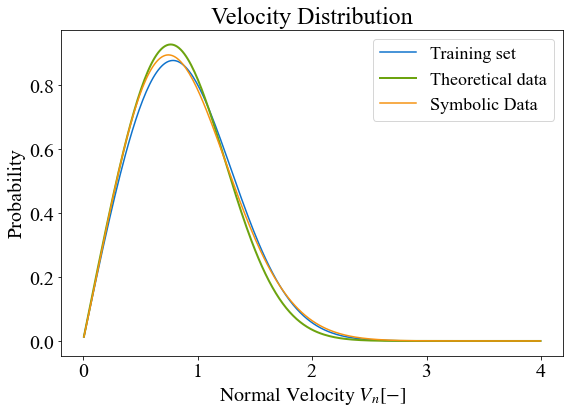

Theoretical SEOE = 0.020
Training SEOE = 0.015


2*x*exp(-(x + 0.041*y + 0.001225)**2)/I0(x + y)

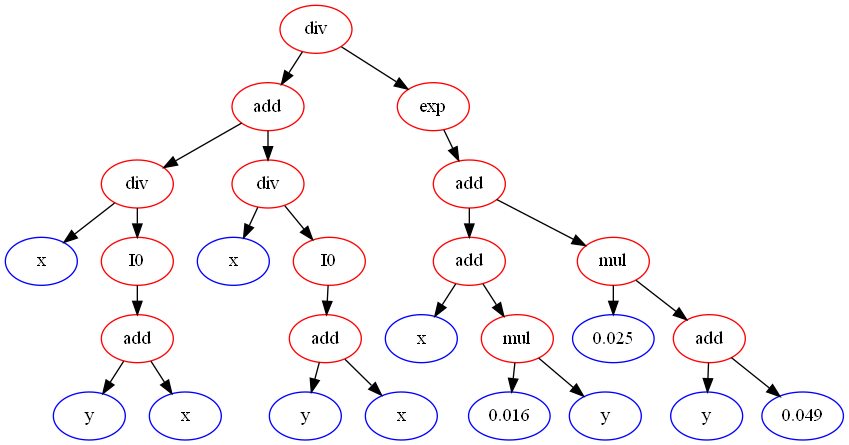

Total Time: 255.894 s


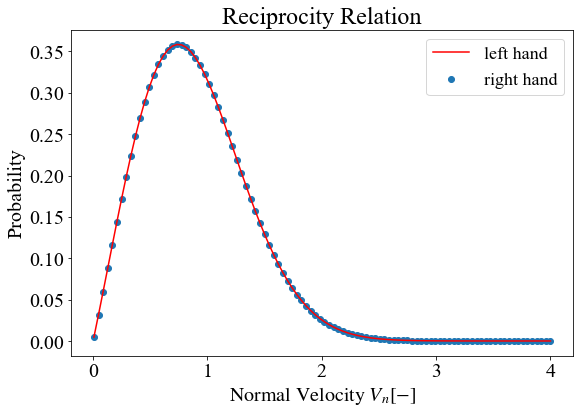

Fitness information: ---------- 
 Error: 0.0009306454553030393 
 P_1: 0.0                  
 P_2: 0.012446111003352245 
 P_3: 0.0008323657822850772
--------------------------------------0.01--------------------------------------


<string>:1: RuntimeWarning: invalid value encountered in multiply
<ipython-input-11-a6497ed68dc1>:136: RuntimeWarning: invalid value encountered in subtract
  P_3 = np.sqrt(np.sum((left-right)**2))
<ipython-input-11-a6497ed68dc1>:100: RuntimeWarning: overflow encountered in square
  numerator = np.sum((y_true - y_pred)**2)
<ipython-input-11-a6497ed68dc1>:141: RuntimeWarning: invalid value encountered in double_scalars
  errors = error + self._penelty_coeff[0] * P_1 + self._penelty_coeff[
D:\SoftwareAPPs\Anaconda\AnacondaInstaller\lib\site-packages\scipy\integrate\_quadrature.py:398: RuntimeWarning: invalid value encountered in add
  tmp = hsum/6.0 * (y[slice0]*(2-1.0/h0divh1) +
D:\SoftwareAPPs\Anaconda\AnacondaInstaller\lib\site-packages\numpy\core\fromnumeric.py:87: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
<string>:1: RuntimeWarning: invalid value encountered in subtract
<string>:1: RuntimeWarning: invalid value enc

   	      	       fitness        	         size         
   	      	----------------------	----------------------
gen	nevals	gen	min	nevals	gen	min	nevals
0  	2000  	0  	nan	2000  	0  	2  	2000  
1  	1654  	1  	nan	1654  	1  	1  	1654  
2  	1653  	2  	nan	1653  	2  	1  	1653  
3  	1645  	3  	nan	1645  	3  	1  	1645  
4  	1609  	4  	nan	1609  	4  	1  	1609  
5  	1657  	5  	nan	1657  	5  	1  	1657  
6  	1663  	6  	nan	1663  	6  	1  	1663  
7  	1654  	7  	nan	1654  	7  	1  	1654  
8  	1681  	8  	nan	1681  	8  	1  	1681  


D:\SoftwareAPPs\Anaconda\AnacondaInstaller\lib\site-packages\numpy\core\fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


9  	1604  	9  	nan	1604  	9  	1  	1604  
The instance has been deleted
10 	1627  	10 	nan	1627  	10 	1  	1627  
11 	1620  	11 	nan	1620  	11 	1  	1620  
12 	1655  	12 	nan	1655  	12 	1  	1655  
13 	1650  	13 	nan	1650  	13 	1  	1650  
14 	1620  	14 	nan	1620  	14 	1  	1620  
15 	1639  	15 	nan	1639  	15 	1  	1639  
16 	1647  	16 	nan	1647  	16 	1  	1647  
17 	1664  	17 	nan	1664  	17 	1  	1664  
18 	1652  	18 	nan	1652  	18 	1  	1652  
19 	1652  	19 	nan	1652  	19 	1  	1652  
20 	1631  	20 	nan	1631  	20 	1  	1631  
21 	1646  	21 	nan	1646  	21 	1  	1646  
22 	1619  	22 	nan	1619  	22 	1  	1619  
23 	1637  	23 	nan	1637  	23 	1  	1637  
24 	1655  	24 	nan	1655  	24 	1  	1655  
25 	1654  	25 	nan	1654  	25 	1  	1654  
26 	1662  	26 	nan	1662  	26 	1  	1662  
27 	1636  	27 	nan	1636  	27 	1  	1636  
28 	1623  	28 	nan	1623  	28 	1  	1623  
29 	1618  	29 	nan	1618  	29 	1  	1618  
30 	1665  	30 	nan	1665  	30 	1  	1665  
31 	1695  	31 	nan	1695  	31 	1  	1695  
32 	1662  	32 	0.00181639	1

183	1646  	183	nan       	1646  	183	1  	1646  
184	1682  	184	nan       	1682  	184	1  	1682  
185	1643  	185	nan       	1643  	185	1  	1643  
186	1672  	186	nan       	1672  	186	1  	1672  
187	1650  	187	nan       	1650  	187	1  	1650  
188	1652  	188	nan       	1652  	188	1  	1652  
189	1633  	189	nan       	1633  	189	1  	1633  
190	1621  	190	nan       	1621  	190	1  	1621  
191	1628  	191	0.00167102	1628  	191	1  	1628  
192	1608  	192	0.00167102	1608  	192	1  	1608  
193	1695  	193	nan       	1695  	193	1  	1695  
194	1639  	194	nan       	1639  	194	1  	1639  
195	1656  	195	nan       	1656  	195	1  	1656  
196	1637  	196	0.00167102	1637  	196	1  	1637  
197	1642  	197	0.00167102	1642  	197	1  	1642  
198	1660  	198	0.00167102	1660  	198	1  	1660  
199	1649  	199	nan       	1649  	199	1  	1649  
200	1616  	200	nan       	1616  	200	1  	1616  


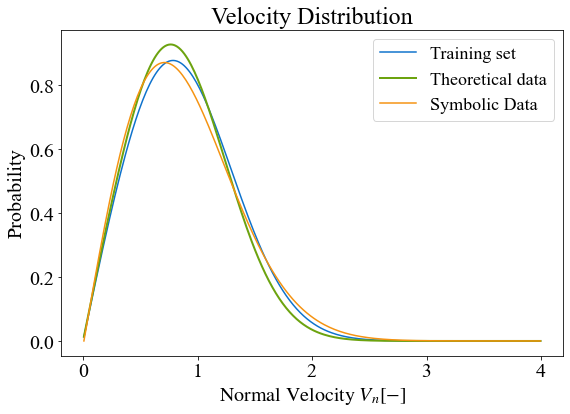

Theoretical SEOE = 0.032
Training SEOE = 0.027


(x*y*(I0(0.183) + 1.045678375) + 0.013858)*exp(-x**2)/y

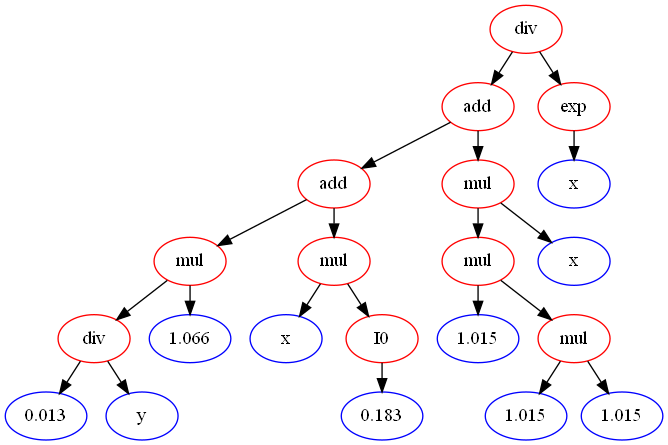

Total Time: 147.206 s


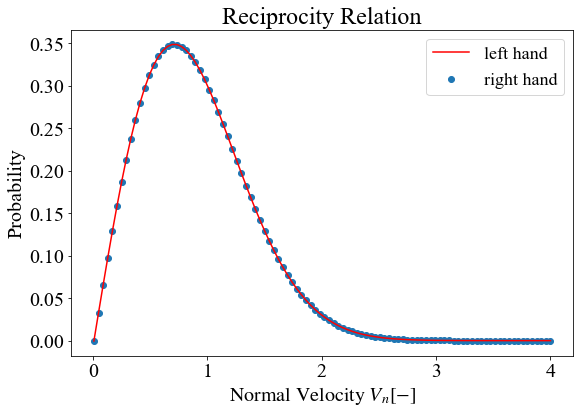

Fitness information: ---------- 
 Error: 0.0016710192150154112 
 P_1: 0.0                  
 P_2: 0.013445749245120986 
 P_3: 3.8466178670227387e-16
-------------------------------------0.005--------------------------------------


<string>:1: RuntimeWarning: invalid value encountered in multiply
<ipython-input-11-a6497ed68dc1>:136: RuntimeWarning: invalid value encountered in subtract
  P_3 = np.sqrt(np.sum((left-right)**2))
<ipython-input-11-a6497ed68dc1>:100: RuntimeWarning: overflow encountered in square
  numerator = np.sum((y_true - y_pred)**2)
<ipython-input-11-a6497ed68dc1>:141: RuntimeWarning: invalid value encountered in double_scalars
  errors = error + self._penelty_coeff[0] * P_1 + self._penelty_coeff[
D:\SoftwareAPPs\Anaconda\AnacondaInstaller\lib\site-packages\scipy\integrate\_quadrature.py:398: RuntimeWarning: invalid value encountered in add
  tmp = hsum/6.0 * (y[slice0]*(2-1.0/h0divh1) +
D:\SoftwareAPPs\Anaconda\AnacondaInstaller\lib\site-packages\numpy\core\fromnumeric.py:87: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
<string>:1: RuntimeWarning: invalid value encountered in subtract
<string>:1: RuntimeWarning: invalid value enc

   	      	       fitness        	         size         
   	      	----------------------	----------------------
gen	nevals	gen	min	nevals	gen	min	nevals
0  	2000  	0  	nan	2000  	0  	2  	2000  
The instance has been deleted
1  	1673  	1  	nan	1673  	1  	1  	1673  
2  	1658  	2  	nan	1658  	2  	1  	1658  
3  	1651  	3  	nan	1651  	3  	1  	1651  
4  	1655  	4  	nan	1655  	4  	1  	1655  
5  	1670  	5  	nan	1670  	5  	1  	1670  
6  	1660  	6  	nan	1660  	6  	1  	1660  
7  	1664  	7  	nan	1664  	7  	1  	1664  
8  	1645  	8  	nan	1645  	8  	1  	1645  
9  	1655  	9  	nan	1655  	9  	1  	1655  
10 	1599  	10 	nan	1599  	10 	1  	1599  
11 	1642  	11 	nan	1642  	11 	1  	1642  
12 	1674  	12 	nan	1674  	12 	1  	1674  
13 	1639  	13 	nan	1639  	13 	1  	1639  
14 	1673  	14 	nan	1673  	14 	1  	1673  
15 	1625  	15 	nan	1625  	15 	1  	1625  
16 	1655  	16 	nan	1655  	16 	1  	1655  
17 	1678  	17 	nan	1678  	17 	1  	1678  
18 	1634  	18 	nan	1634  	18 	1  	1634  
19 	1641  	19 	nan	1641  	19 	1  	16

176	1682  	176	nan       	1682  	176	1  	1682  
177	1646  	177	nan       	1646  	177	1  	1646  
178	1701  	178	nan       	1701  	178	1  	1701  
179	1630  	179	nan       	1630  	179	1  	1630  
180	1651  	180	nan       	1651  	180	1  	1651  
181	1688  	181	0.00134502	1688  	181	1  	1688  
182	1642  	182	nan       	1642  	182	1  	1642  
183	1644  	183	nan       	1644  	183	1  	1644  
184	1662  	184	nan       	1662  	184	1  	1662  
185	1609  	185	nan       	1609  	185	1  	1609  
186	1642  	186	nan       	1642  	186	1  	1642  
187	1636  	187	nan       	1636  	187	1  	1636  
188	1641  	188	0.00134414	1641  	188	1  	1641  
189	1604  	189	nan       	1604  	189	1  	1604  
190	1683  	190	nan       	1683  	190	1  	1683  
191	1624  	191	nan       	1624  	191	1  	1624  
192	1656  	192	nan       	1656  	192	1  	1656  
193	1646  	193	nan       	1646  	193	1  	1646  
194	1633  	194	nan       	1633  	194	1  	1633  
195	1664  	195	nan       	1664  	195	1  	1664  
196	1648  	196	nan       	1648  	196	1  

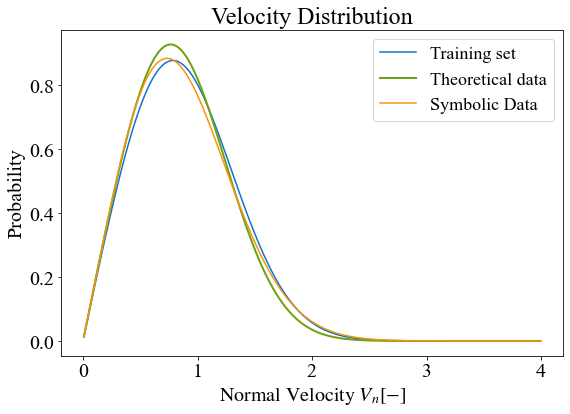

Theoretical SEOE = 0.022
Training SEOE = 0.020


2.06359649122807*x*exp(-0.985116*x**2)/I0(x + y)

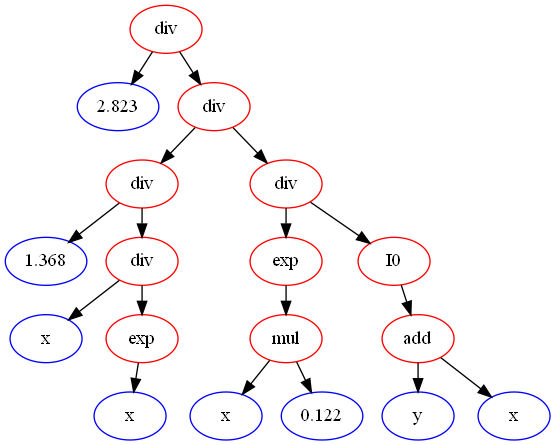

Total Time: 228.595 s


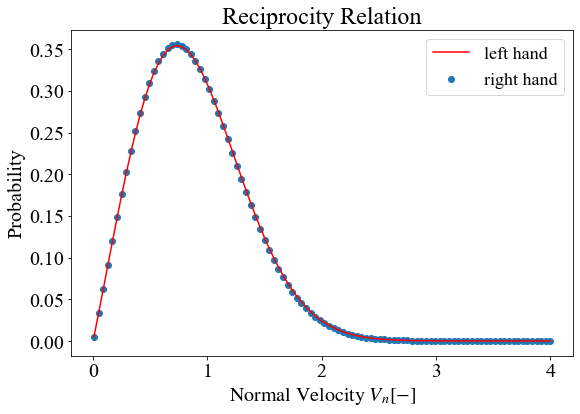

Fitness information: ---------- 
 Error: 0.0012307347507874071 
 P_1: 0.0                  
 P_2: 0.0036256849632653187 
 P_3: 0.0226814571480967  
-------------------------------------0.001--------------------------------------


<string>:1: RuntimeWarning: invalid value encountered in multiply
<ipython-input-11-a6497ed68dc1>:136: RuntimeWarning: invalid value encountered in subtract
  P_3 = np.sqrt(np.sum((left-right)**2))
<ipython-input-11-a6497ed68dc1>:100: RuntimeWarning: overflow encountered in square
  numerator = np.sum((y_true - y_pred)**2)
<ipython-input-11-a6497ed68dc1>:141: RuntimeWarning: invalid value encountered in double_scalars
  errors = error + self._penelty_coeff[0] * P_1 + self._penelty_coeff[
D:\SoftwareAPPs\Anaconda\AnacondaInstaller\lib\site-packages\scipy\integrate\_quadrature.py:398: RuntimeWarning: invalid value encountered in add
  tmp = hsum/6.0 * (y[slice0]*(2-1.0/h0divh1) +
D:\SoftwareAPPs\Anaconda\AnacondaInstaller\lib\site-packages\numpy\core\fromnumeric.py:87: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
<string>:1: RuntimeWarning: invalid value encountered in subtract
<string>:1: RuntimeWarning: invalid value enc

   	      	       fitness        	         size         
   	      	----------------------	----------------------
gen	nevals	gen	min	nevals	gen	min	nevals
0  	2000  	0  	nan	2000  	0  	2  	2000  
The instance has been deleted
1  	1653  	1  	nan	1653  	1  	1  	1653  
2  	1659  	2  	nan	1659  	2  	1  	1659  
3  	1613  	3  	nan	1613  	3  	1  	1613  
4  	1635  	4  	nan	1635  	4  	1  	1635  
5  	1686  	5  	nan	1686  	5  	1  	1686  
6  	1655  	6  	nan	1655  	6  	1  	1655  
7  	1664  	7  	nan	1664  	7  	1  	1664  
8  	1675  	8  	nan	1675  	8  	1  	1675  
9  	1649  	9  	nan	1649  	9  	1  	1649  
10 	1630  	10 	nan	1630  	10 	1  	1630  
11 	1628  	11 	nan	1628  	11 	1  	1628  
12 	1623  	12 	nan	1623  	12 	1  	1623  
13 	1665  	13 	nan	1665  	13 	1  	1665  
14 	1652  	14 	nan	1652  	14 	1  	1652  
15 	1648  	15 	nan	1648  	15 	1  	1648  
16 	1624  	16 	nan	1624  	16 	1  	1624  
17 	1683  	17 	nan	1683  	17 	1  	1683  
18 	1659  	18 	nan	1659  	18 	1  	1659  
19 	1644  	19 	nan	1644  	19 	1  	16

171	1683  	171	nan       	1683  	171	1  	1683  
172	1649  	172	nan       	1649  	172	1  	1649  
173	1617  	173	nan       	1617  	173	1  	1617  
174	1643  	174	nan       	1643  	174	1  	1643  
175	1697  	175	0.00147787	1697  	175	1  	1697  
176	1656  	176	0.00147787	1656  	176	1  	1656  
177	1628  	177	0.00147787	1628  	177	1  	1628  
178	1593  	178	0.00147787	1593  	178	1  	1593  
179	1646  	179	nan       	1646  	179	1  	1646  
180	1674  	180	nan       	1674  	180	1  	1674  
181	1641  	181	nan       	1641  	181	1  	1641  
182	1649  	182	nan       	1649  	182	1  	1649  
183	1660  	183	0.00147787	1660  	183	1  	1660  
184	1687  	184	0.00147787	1687  	184	1  	1687  
185	1652  	185	0.00147787	1652  	185	1  	1652  
186	1642  	186	nan       	1642  	186	1  	1642  
187	1639  	187	0.00109629	1639  	187	1  	1639  
188	1675  	188	nan       	1675  	188	1  	1675  
189	1649  	189	nan       	1649  	189	1  	1649  
190	1657  	190	nan       	1657  	190	1  	1657  
191	1651  	191	nan       	1651  	191	1  

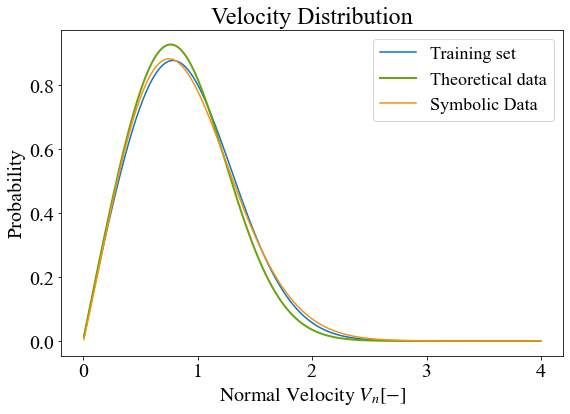

Theoretical SEOE = 0.025
Training SEOE = 0.012


(2.011*x - 0.01011)*exp(-0.95466070135597*(x - 0.01)**2)/I0(x + y)

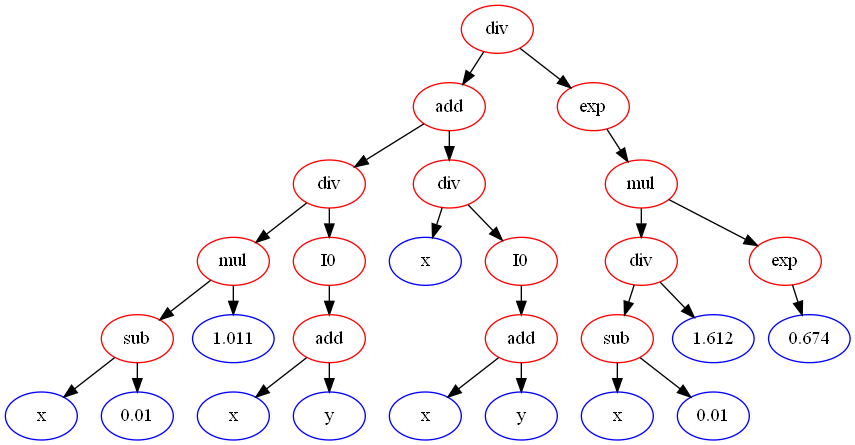

Total Time: 253.673 s


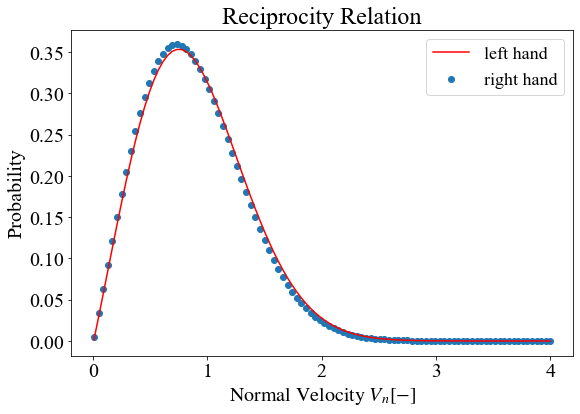

Fitness information: ---------- 
 Error: 0.0007068482503378785 
 P_1: 0.0                  
 P_2: 0.009180035245961227 
 P_3: 0.09681406586132096 
-------------------------------------0.0005-------------------------------------


<string>:1: RuntimeWarning: invalid value encountered in multiply
<ipython-input-11-a6497ed68dc1>:136: RuntimeWarning: invalid value encountered in subtract
  P_3 = np.sqrt(np.sum((left-right)**2))
<ipython-input-11-a6497ed68dc1>:100: RuntimeWarning: overflow encountered in square
  numerator = np.sum((y_true - y_pred)**2)
<ipython-input-11-a6497ed68dc1>:141: RuntimeWarning: invalid value encountered in double_scalars
  errors = error + self._penelty_coeff[0] * P_1 + self._penelty_coeff[
D:\SoftwareAPPs\Anaconda\AnacondaInstaller\lib\site-packages\scipy\integrate\_quadrature.py:398: RuntimeWarning: invalid value encountered in add
  tmp = hsum/6.0 * (y[slice0]*(2-1.0/h0divh1) +
D:\SoftwareAPPs\Anaconda\AnacondaInstaller\lib\site-packages\numpy\core\fromnumeric.py:87: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
<string>:1: RuntimeWarning: invalid value encountered in subtract
<string>:1: RuntimeWarning: invalid value enc

   	      	       fitness        	         size         
   	      	----------------------	----------------------
gen	nevals	gen	min	nevals	gen	min	nevals
0  	2000  	0  	nan	2000  	0  	2  	2000  
The instance has been deleted
1  	1645  	1  	nan	1645  	1  	1  	1645  
2  	1624  	2  	nan	1624  	2  	1  	1624  
3  	1626  	3  	nan	1626  	3  	1  	1626  
4  	1675  	4  	nan	1675  	4  	1  	1675  
5  	1649  	5  	nan	1649  	5  	1  	1649  
6  	1646  	6  	nan	1646  	6  	1  	1646  
7  	1653  	7  	nan	1653  	7  	1  	1653  
8  	1608  	8  	nan	1608  	8  	1  	1608  
9  	1645  	9  	nan	1645  	9  	1  	1645  
10 	1621  	10 	nan	1621  	10 	1  	1621  
11 	1608  	11 	nan	1608  	11 	1  	1608  
12 	1625  	12 	nan	1625  	12 	1  	1625  
13 	1619  	13 	nan	1619  	13 	1  	1619  
14 	1645  	14 	nan	1645  	14 	1  	1645  
15 	1665  	15 	nan	1665  	15 	1  	1665  
16 	1611  	16 	nan	1611  	16 	1  	1611  
17 	1658  	17 	nan	1658  	17 	1  	1658  
18 	1662  	18 	nan	1662  	18 	1  	1662  
19 	1685  	19 	nan	1685  	19 	1  	16

171	1671  	171	0.00117923	1671  	171	1  	1671  
172	1636  	172	0.00117763	1636  	172	1  	1636  
173	1621  	173	nan       	1621  	173	1  	1621  
174	1640  	174	nan       	1640  	174	1  	1640  
175	1625  	175	0.00117701	1625  	175	1  	1625  
176	1637  	176	0.00117701	1637  	176	1  	1637  
177	1668  	177	nan       	1668  	177	1  	1668  
178	1670  	178	nan       	1670  	178	1  	1670  
179	1668  	179	0.00117701	1668  	179	1  	1668  
180	1647  	180	0.00117701	1647  	180	1  	1647  
181	1667  	181	0.00117701	1667  	181	1  	1667  
182	1638  	182	nan       	1638  	182	1  	1638  
183	1664  	183	0.00117701	1664  	183	1  	1664  
184	1680  	184	0.00117701	1680  	184	1  	1680  
185	1628  	185	0.00117701	1628  	185	1  	1628  
186	1650  	186	0.00117701	1650  	186	1  	1650  
187	1680  	187	nan       	1680  	187	1  	1680  
188	1659  	188	0.00117701	1659  	188	1  	1659  
189	1687  	189	nan       	1687  	189	1  	1687  
190	1601  	190	0.00117701	1601  	190	1  	1601  
191	1642  	191	nan       	1642  	191	1  

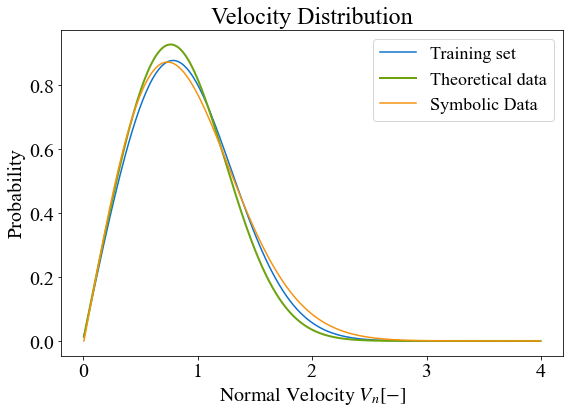

Theoretical SEOE = 0.033
Training SEOE = 0.019


(0.09398*x*y + 2*x + 0.02*y*(x + 0.796))*exp(-1.016096256256*(x - 0.0198409549054777*y*(y - 2.665))**2)

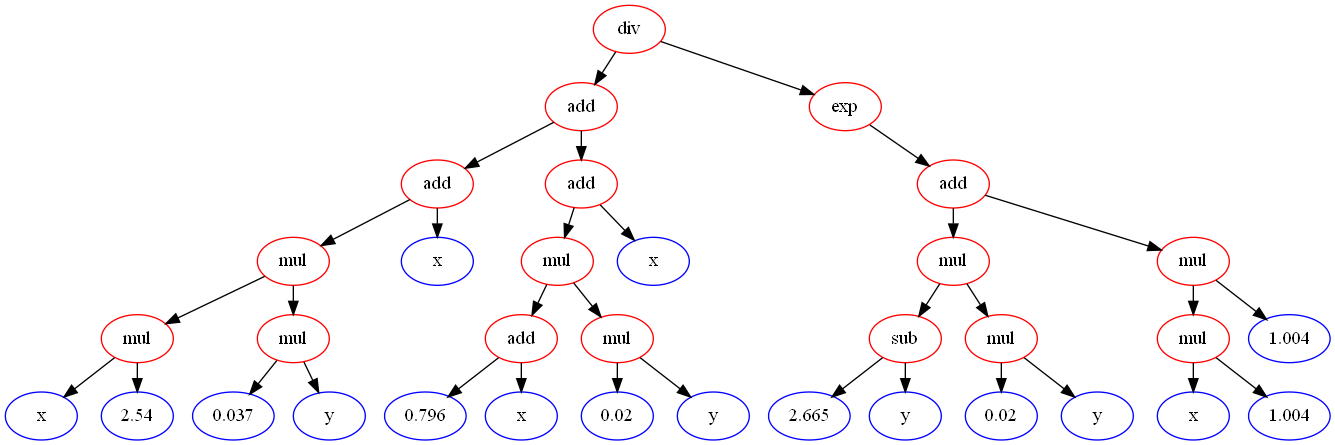

Total Time: 144.061 s


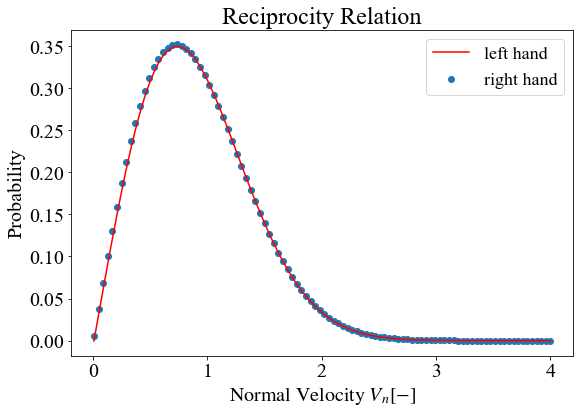

Fitness information: ---------- 
 Error: 0.0011499553045842016 
 P_1: 6.957163265938777e-07 
 P_2: 0.030263571520203092 
 P_3: 0.0527163035838334  
-------------------------------------0.0001-------------------------------------


<string>:1: RuntimeWarning: invalid value encountered in multiply
<ipython-input-11-a6497ed68dc1>:136: RuntimeWarning: invalid value encountered in subtract
  P_3 = np.sqrt(np.sum((left-right)**2))
<ipython-input-11-a6497ed68dc1>:100: RuntimeWarning: overflow encountered in square
  numerator = np.sum((y_true - y_pred)**2)
<ipython-input-11-a6497ed68dc1>:141: RuntimeWarning: invalid value encountered in double_scalars
  errors = error + self._penelty_coeff[0] * P_1 + self._penelty_coeff[
D:\SoftwareAPPs\Anaconda\AnacondaInstaller\lib\site-packages\scipy\integrate\_quadrature.py:398: RuntimeWarning: invalid value encountered in add
  tmp = hsum/6.0 * (y[slice0]*(2-1.0/h0divh1) +
D:\SoftwareAPPs\Anaconda\AnacondaInstaller\lib\site-packages\numpy\core\fromnumeric.py:87: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
<string>:1: RuntimeWarning: invalid value encountered in subtract
<string>:1: RuntimeWarning: invalid value enc

   	      	       fitness        	         size         
   	      	----------------------	----------------------
gen	nevals	gen	min	nevals	gen	min	nevals
0  	2000  	0  	nan	2000  	0  	2  	2000  
1  	1646  	1  	nan	1646  	1  	1  	1646  
2  	1626  	2  	nan	1626  	2  	1  	1626  
3  	1616  	3  	nan	1616  	3  	1  	1616  
4  	1653  	4  	nan	1653  	4  	1  	1653  
5  	1645  	5  	nan	1645  	5  	1  	1645  
6  	1661  	6  	nan	1661  	6  	1  	1661  
7  	1611  	7  	nan	1611  	7  	1  	1611  
8  	1682  	8  	nan	1682  	8  	1  	1682  
9  	1671  	9  	nan	1671  	9  	1  	1671  
The instance has been deleted
10 	1647  	10 	nan	1647  	10 	1  	1647  
11 	1629  	11 	nan	1629  	11 	1  	1629  
12 	1644  	12 	nan	1644  	12 	1  	1644  
13 	1628  	13 	nan	1628  	13 	1  	1628  
14 	1638  	14 	nan	1638  	14 	1  	1638  
15 	1603  	15 	nan	1603  	15 	1  	1603  
16 	1646  	16 	nan	1646  	16 	1  	1646  
17 	1626  	17 	nan	1626  	17 	1  	1626  
18 	1624  	18 	nan	1624  	18 	1  	1624  
19 	1663  	19 	nan	1663  	19 	1  	16

169	1678  	169	nan        	1678  	169	1  	1678  
170	1643  	170	nan        	1643  	170	1  	1643  
171	1649  	171	nan        	1649  	171	1  	1649  
172	1635  	172	0.000713136	1635  	172	1  	1635  
173	1671  	173	0.000713136	1671  	173	1  	1671  
174	1638  	174	0.000713136	1638  	174	1  	1638  
175	1637  	175	0.000713136	1637  	175	1  	1637  
176	1677  	176	nan        	1677  	176	1  	1677  
177	1639  	177	nan        	1639  	177	1  	1639  
178	1675  	178	nan        	1675  	178	1  	1675  
179	1665  	179	nan        	1665  	179	1  	1665  
180	1633  	180	nan        	1633  	180	1  	1633  
181	1623  	181	nan        	1623  	181	1  	1623  
182	1682  	182	nan        	1682  	182	1  	1682  
183	1642  	183	nan        	1642  	183	1  	1642  
184	1634  	184	0.000713136	1634  	184	1  	1634  
185	1648  	185	0.000713136	1648  	185	1  	1648  
186	1648  	186	0.000713136	1648  	186	1  	1648  
187	1654  	187	nan        	1654  	187	1  	1654  
188	1650  	188	nan        	1650  	188	1  	1650  
189	1667  	189	nan  

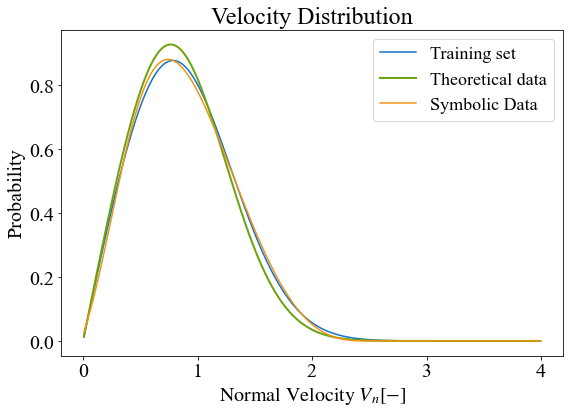

Theoretical SEOE = 0.029
Training SEOE = 0.011


(x + 0.019)*(x + 1.294)/(((x - 0.738)*(x + 0.019) + exp(x**2))*I0((x + y)/(x - 2.702))*I0(x - 0.942))

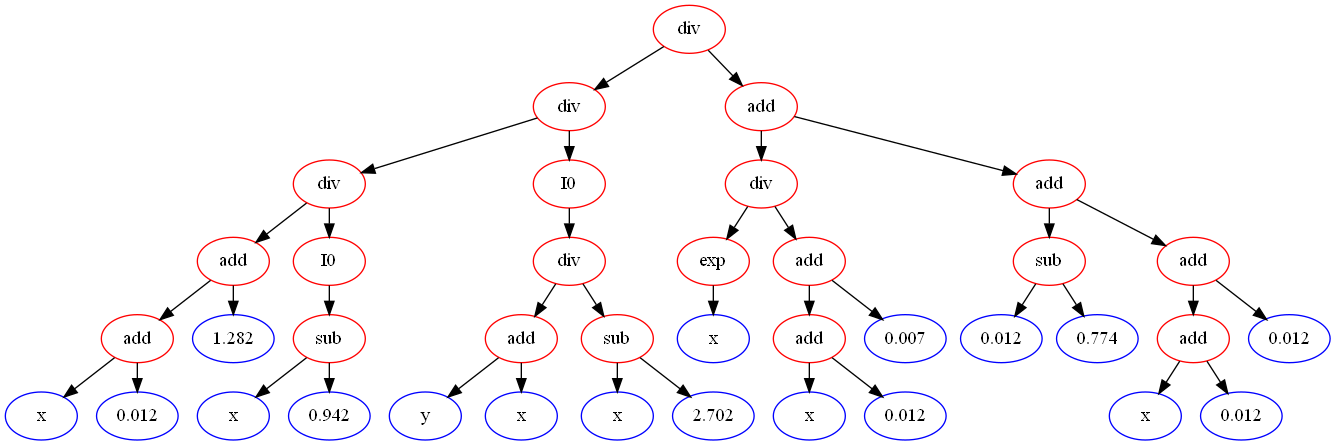

Total Time: 478.854 s


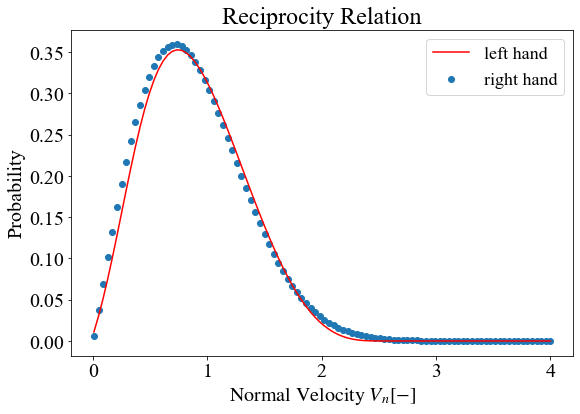

Fitness information: ---------- 
 Error: 0.0006948191865489608 
 P_1: 0.0                  
 P_2: 0.003393311067619198 
 P_3: 0.18316812759556536 
-------------------------------------5e-05--------------------------------------


<string>:1: RuntimeWarning: invalid value encountered in multiply
<ipython-input-11-a6497ed68dc1>:136: RuntimeWarning: invalid value encountered in subtract
  P_3 = np.sqrt(np.sum((left-right)**2))
<ipython-input-11-a6497ed68dc1>:100: RuntimeWarning: overflow encountered in square
  numerator = np.sum((y_true - y_pred)**2)
<ipython-input-11-a6497ed68dc1>:141: RuntimeWarning: invalid value encountered in double_scalars
  errors = error + self._penelty_coeff[0] * P_1 + self._penelty_coeff[
D:\SoftwareAPPs\Anaconda\AnacondaInstaller\lib\site-packages\scipy\integrate\_quadrature.py:398: RuntimeWarning: invalid value encountered in add
  tmp = hsum/6.0 * (y[slice0]*(2-1.0/h0divh1) +
D:\SoftwareAPPs\Anaconda\AnacondaInstaller\lib\site-packages\numpy\core\fromnumeric.py:87: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
<string>:1: RuntimeWarning: invalid value encountered in subtract
<string>:1: RuntimeWarning: invalid value enc

   	      	       fitness        	         size         
   	      	----------------------	----------------------
gen	nevals	gen	min	nevals	gen	min	nevals
0  	2000  	0  	nan	2000  	0  	2  	2000  
1  	1647  	1  	nan	1647  	1  	1  	1647  
2  	1676  	2  	nan	1676  	2  	1  	1676  
3  	1678  	3  	nan	1678  	3  	1  	1678  
4  	1594  	4  	nan	1594  	4  	1  	1594  
5  	1659  	5  	nan	1659  	5  	1  	1659  
6  	1668  	6  	nan	1668  	6  	1  	1668  
7  	1663  	7  	nan	1663  	7  	1  	1663  
The instance has been deleted
8  	1651  	8  	nan	1651  	8  	1  	1651  
9  	1670  	9  	nan	1670  	9  	1  	1670  
10 	1664  	10 	nan	1664  	10 	1  	1664  
11 	1639  	11 	nan	1639  	11 	1  	1639  
12 	1676  	12 	nan	1676  	12 	1  	1676  
13 	1632  	13 	nan	1632  	13 	1  	1632  
14 	1635  	14 	nan	1635  	14 	1  	1635  
15 	1642  	15 	nan	1642  	15 	1  	1642  
16 	1629  	16 	nan	1629  	16 	1  	1629  
17 	1656  	17 	nan	1656  	17 	1  	1656  
18 	1635  	18 	nan	1635  	18 	1  	1635  
19 	1697  	19 	nan	1697  	19 	1  	16

D:\SoftwareAPPs\Anaconda\AnacondaInstaller\lib\site-packages\numpy\core\fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


45 	1616  	45 	nan        	1616  	45 	1  	1616  
46 	1629  	46 	nan        	1629  	46 	1  	1629  
47 	1621  	47 	nan        	1621  	47 	1  	1621  
48 	1678  	48 	nan        	1678  	48 	1  	1678  
49 	1665  	49 	nan        	1665  	49 	1  	1665  
50 	1630  	50 	nan        	1630  	50 	1  	1630  
51 	1671  	51 	nan        	1671  	51 	1  	1671  
52 	1665  	52 	nan        	1665  	52 	1  	1665  
53 	1658  	53 	nan        	1658  	53 	1  	1658  
54 	1635  	54 	0.000553179	1635  	54 	1  	1635  
55 	1628  	55 	0.000553179	1628  	55 	1  	1628  
56 	1626  	56 	nan        	1626  	56 	1  	1626  
57 	1664  	57 	nan        	1664  	57 	1  	1664  
58 	1623  	58 	nan        	1623  	58 	1  	1623  
59 	1637  	59 	nan        	1637  	59 	1  	1637  
60 	1644  	60 	nan        	1644  	60 	1  	1644  
61 	1619  	61 	nan        	1619  	61 	1  	1619  
62 	1661  	62 	0.000548029	1661  	62 	1  	1661  
63 	1664  	63 	nan        	1664  	63 	1  	1664  
64 	1597  	64 	nan        	1597  	64 	1  	1597  
65 	1668  	65 	nan  

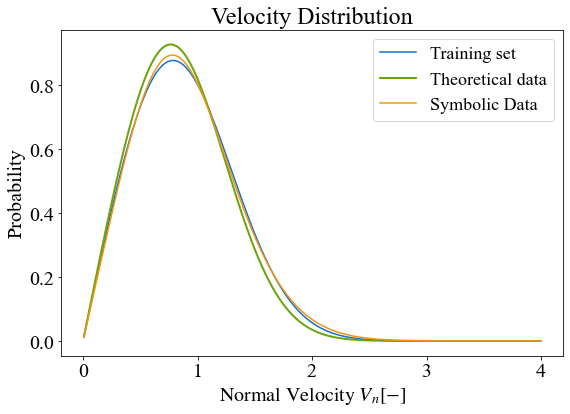

Theoretical SEOE = 0.025
Training SEOE = 0.008


x*y*(x + 1.68469991546915)/(x*y*(exp(x**2) - 0.723) - 0.244514106583072*x + 1.067*y)

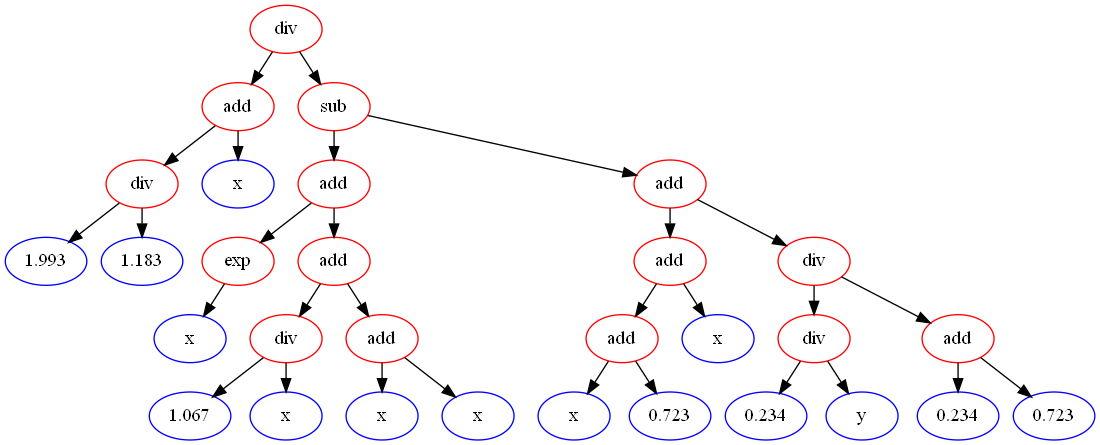

Total Time: 160.159 s


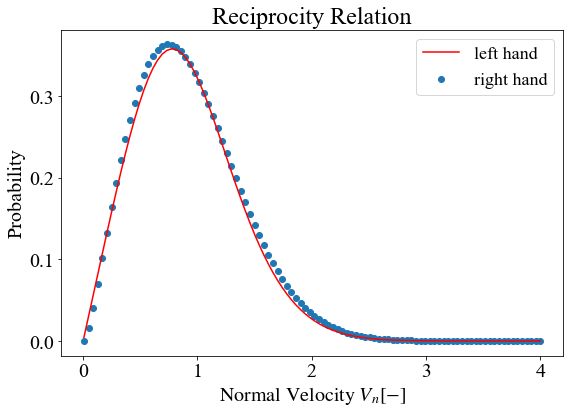

Fitness information: ---------- 
 Error: 0.000489368113406691 
 P_1: 0.0                  
 P_2: 0.0051608007005137235 
 P_3: 0.12316577805057924 
-------------------------------------1e-05--------------------------------------
The instance has been deleted
   	      	       fitness        	         size         
   	      	----------------------	----------------------
gen	nevals	gen	min	nevals	gen	min	nevals
0  	2000  	0  	nan	2000  	0  	2  	2000  


<string>:1: RuntimeWarning: invalid value encountered in multiply
<ipython-input-11-a6497ed68dc1>:136: RuntimeWarning: invalid value encountered in subtract
  P_3 = np.sqrt(np.sum((left-right)**2))
<ipython-input-11-a6497ed68dc1>:100: RuntimeWarning: overflow encountered in square
  numerator = np.sum((y_true - y_pred)**2)
<ipython-input-11-a6497ed68dc1>:141: RuntimeWarning: invalid value encountered in double_scalars
  errors = error + self._penelty_coeff[0] * P_1 + self._penelty_coeff[
D:\SoftwareAPPs\Anaconda\AnacondaInstaller\lib\site-packages\scipy\integrate\_quadrature.py:398: RuntimeWarning: invalid value encountered in add
  tmp = hsum/6.0 * (y[slice0]*(2-1.0/h0divh1) +
D:\SoftwareAPPs\Anaconda\AnacondaInstaller\lib\site-packages\numpy\core\fromnumeric.py:87: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
<string>:1: RuntimeWarning: invalid value encountered in subtract
<string>:1: RuntimeWarning: invalid value enc

1  	1628  	1  	nan	1628  	1  	1  	1628  
2  	1642  	2  	nan	1642  	2  	1  	1642  
3  	1644  	3  	nan	1644  	3  	1  	1644  
4  	1638  	4  	nan	1638  	4  	1  	1638  
5  	1665  	5  	nan	1665  	5  	1  	1665  
6  	1648  	6  	nan	1648  	6  	1  	1648  
7  	1672  	7  	nan	1672  	7  	1  	1672  
8  	1667  	8  	nan	1667  	8  	1  	1667  
9  	1658  	9  	nan	1658  	9  	1  	1658  
10 	1619  	10 	nan	1619  	10 	1  	1619  
11 	1606  	11 	nan	1606  	11 	1  	1606  
12 	1639  	12 	nan	1639  	12 	1  	1639  
13 	1644  	13 	nan	1644  	13 	1  	1644  
14 	1663  	14 	nan	1663  	14 	1  	1663  
15 	1649  	15 	nan	1649  	15 	1  	1649  
16 	1632  	16 	nan	1632  	16 	1  	1632  
17 	1671  	17 	nan	1671  	17 	1  	1671  
18 	1630  	18 	nan	1630  	18 	1  	1630  
19 	1668  	19 	nan	1668  	19 	1  	1668  
20 	1651  	20 	nan	1651  	20 	1  	1651  
21 	1656  	21 	nan	1656  	21 	1  	1656  
22 	1667  	22 	nan	1667  	22 	1  	1667  
23 	1658  	23 	nan	1658  	23 	1  	1658  
24 	1665  	24 	nan	1665  	24 	1  	1665  
25 	1631  	25 	n

D:\SoftwareAPPs\Anaconda\AnacondaInstaller\lib\site-packages\numpy\core\fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


45 	1658  	45 	nan       	1658  	45 	1  	1658  
46 	1642  	46 	nan       	1642  	46 	1  	1642  
47 	1615  	47 	nan       	1615  	47 	1  	1615  
48 	1670  	48 	nan       	1670  	48 	1  	1670  
49 	1667  	49 	nan       	1667  	49 	1  	1667  
50 	1671  	50 	nan       	1671  	50 	1  	1671  
51 	1651  	51 	nan       	1651  	51 	1  	1651  
52 	1655  	52 	nan       	1655  	52 	1  	1655  
53 	1696  	53 	nan       	1696  	53 	1  	1696  
54 	1634  	54 	nan       	1634  	54 	1  	1634  
55 	1683  	55 	nan       	1683  	55 	1  	1683  
56 	1685  	56 	nan       	1685  	56 	1  	1685  
57 	1659  	57 	nan       	1659  	57 	1  	1659  
58 	1673  	58 	nan       	1673  	58 	1  	1673  
59 	1622  	59 	0.00151384	1622  	59 	1  	1622  
60 	1666  	60 	0.00151384	1666  	60 	1  	1666  
61 	1641  	61 	0.00150024	1641  	61 	1  	1641  
62 	1633  	62 	nan       	1633  	62 	1  	1633  
63 	1645  	63 	nan       	1645  	63 	1  	1645  
64 	1697  	64 	nan       	1697  	64 	1  	1697  
65 	1675  	65 	nan       	1675  	65 	1  

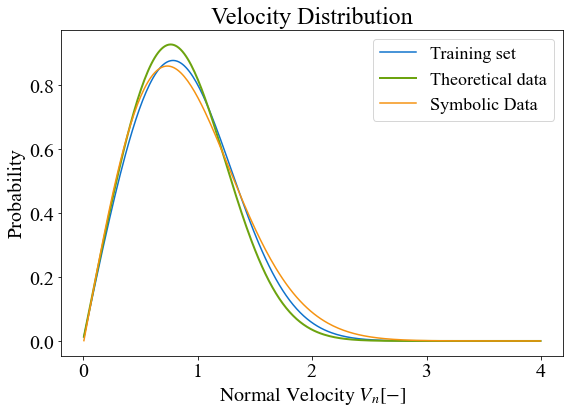

Theoretical SEOE = 0.038
Training SEOE = 0.021


(x - 0.007)*(I0(0.36) + I0(0.419))*exp(0.049729*x**2*y**2 - (x - 0.021)**2)/(I0(0.36)*I0(0.419))

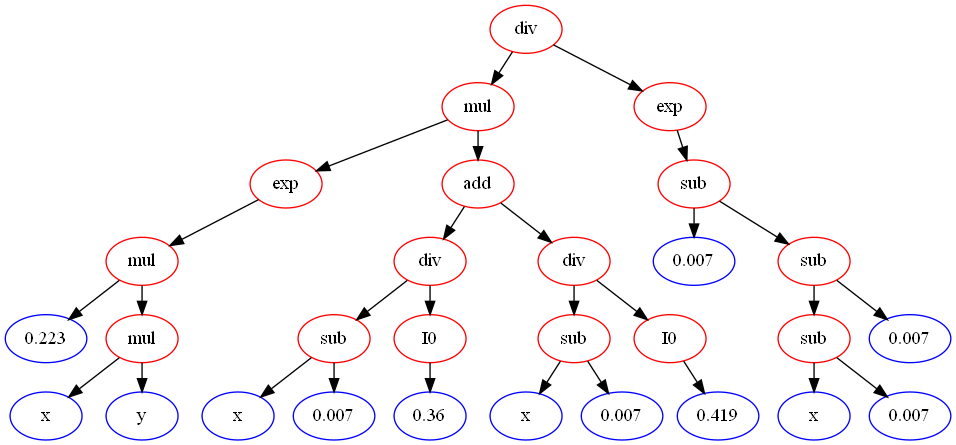

Total Time: 162.168 s


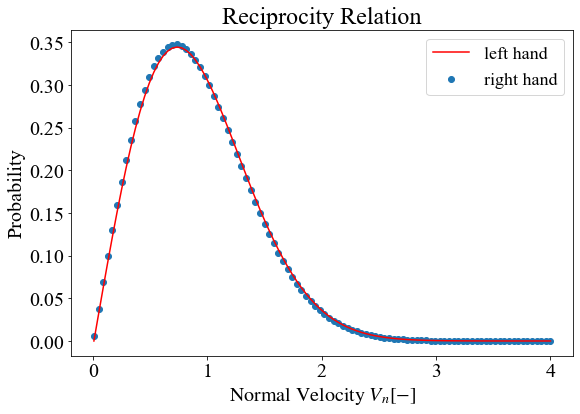

Fitness information: ---------- 
 Error: 0.0013055203656248203 
 P_1: 0.0                  
 P_2: 0.029514522169511226 
 P_3: 0.05752360073281801 
-------------------------------------5e-06--------------------------------------


<string>:1: RuntimeWarning: invalid value encountered in multiply
<ipython-input-11-a6497ed68dc1>:136: RuntimeWarning: invalid value encountered in subtract
  P_3 = np.sqrt(np.sum((left-right)**2))
<ipython-input-11-a6497ed68dc1>:100: RuntimeWarning: overflow encountered in square
  numerator = np.sum((y_true - y_pred)**2)
<ipython-input-11-a6497ed68dc1>:141: RuntimeWarning: invalid value encountered in double_scalars
  errors = error + self._penelty_coeff[0] * P_1 + self._penelty_coeff[
D:\SoftwareAPPs\Anaconda\AnacondaInstaller\lib\site-packages\scipy\integrate\_quadrature.py:398: RuntimeWarning: invalid value encountered in add
  tmp = hsum/6.0 * (y[slice0]*(2-1.0/h0divh1) +
D:\SoftwareAPPs\Anaconda\AnacondaInstaller\lib\site-packages\numpy\core\fromnumeric.py:87: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
<string>:1: RuntimeWarning: invalid value encountered in subtract
<string>:1: RuntimeWarning: invalid value enc

   	      	       fitness        	         size         
   	      	----------------------	----------------------
gen	nevals	gen	min	nevals	gen	min	nevals
0  	2000  	0  	nan	2000  	0  	2  	2000  
The instance has been deleted
1  	1638  	1  	nan	1638  	1  	1  	1638  
2  	1666  	2  	nan	1666  	2  	1  	1666  
3  	1677  	3  	nan	1677  	3  	1  	1677  
4  	1671  	4  	nan	1671  	4  	1  	1671  
5  	1610  	5  	nan	1610  	5  	1  	1610  
6  	1680  	6  	nan	1680  	6  	1  	1680  
7  	1655  	7  	nan	1655  	7  	1  	1655  
8  	1618  	8  	nan	1618  	8  	1  	1618  
9  	1645  	9  	nan	1645  	9  	1  	1645  
10 	1630  	10 	nan	1630  	10 	1  	1630  
11 	1622  	11 	nan	1622  	11 	1  	1622  
12 	1636  	12 	nan	1636  	12 	1  	1636  
13 	1641  	13 	nan	1641  	13 	1  	1641  
14 	1631  	14 	nan	1631  	14 	1  	1631  
15 	1646  	15 	nan	1646  	15 	1  	1646  
16 	1639  	16 	nan	1639  	16 	1  	1639  
17 	1675  	17 	nan	1675  	17 	1  	1675  
18 	1661  	18 	nan	1661  	18 	1  	1661  
19 	1652  	19 	nan	1652  	19 	1  	16

176	1660  	176	0.00116403	1660  	176	1  	1660  
177	1654  	177	0.00116403	1654  	177	1  	1654  
178	1661  	178	nan       	1661  	178	1  	1661  
179	1645  	179	0.00114831	1645  	179	1  	1645  
180	1631  	180	0.00114831	1631  	180	1  	1631  
181	1668  	181	nan       	1668  	181	1  	1668  
182	1665  	182	nan       	1665  	182	1  	1665  
183	1643  	183	0.00114831	1643  	183	1  	1643  
184	1670  	184	0.00114831	1670  	184	1  	1670  
185	1675  	185	0.00114831	1675  	185	1  	1675  
186	1646  	186	0.00114831	1646  	186	1  	1646  
187	1660  	187	nan       	1660  	187	1  	1660  
188	1631  	188	nan       	1631  	188	1  	1631  
189	1599  	189	0.00114831	1599  	189	1  	1599  
190	1620  	190	0.00114831	1620  	190	1  	1620  
191	1658  	191	nan       	1658  	191	1  	1658  
192	1657  	192	nan       	1657  	192	1  	1657  
193	1667  	193	0.00114831	1667  	193	1  	1667  
194	1623  	194	0.00114831	1623  	194	1  	1623  
195	1663  	195	0.00114831	1663  	195	1  	1663  
196	1643  	196	nan       	1643  	196	1  

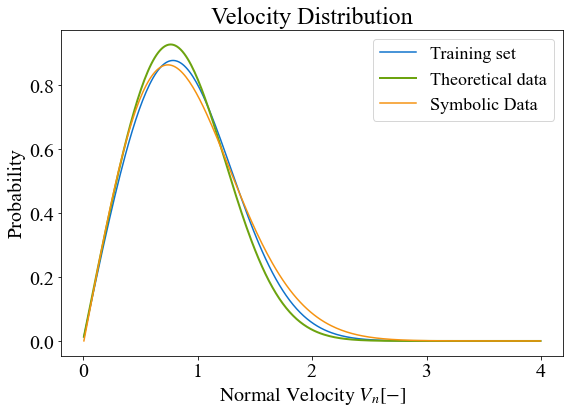

Theoretical SEOE = 0.036
Training SEOE = 0.019


(1.87195763486246*x - 0.013804)*exp(-1.44518289162903*(0.831837690206789*x - 0.831837690206789*I0(0.994) + 1)**2)

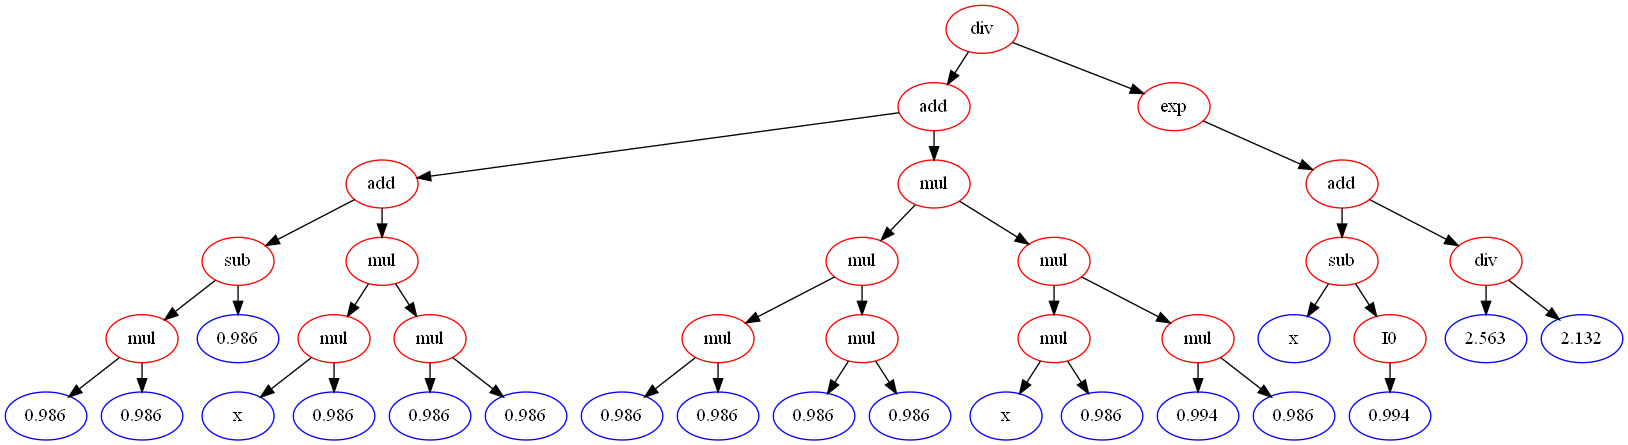

Total Time: 182.483 s


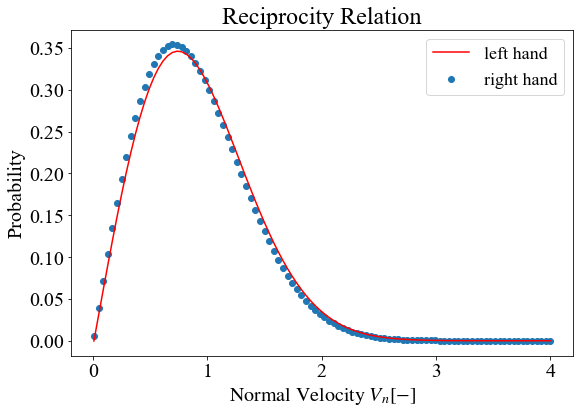

Fitness information: ---------- 
 Error: 0.00114765408687093  
 P_1: 0.0                  
 P_2: 0.026806428414791528 
 P_3: 0.13038224691492536 
-------------------------------------1e-06--------------------------------------


<string>:1: RuntimeWarning: invalid value encountered in multiply
<ipython-input-11-a6497ed68dc1>:136: RuntimeWarning: invalid value encountered in subtract
  P_3 = np.sqrt(np.sum((left-right)**2))
<ipython-input-11-a6497ed68dc1>:100: RuntimeWarning: overflow encountered in square
  numerator = np.sum((y_true - y_pred)**2)
<ipython-input-11-a6497ed68dc1>:141: RuntimeWarning: invalid value encountered in double_scalars
  errors = error + self._penelty_coeff[0] * P_1 + self._penelty_coeff[
D:\SoftwareAPPs\Anaconda\AnacondaInstaller\lib\site-packages\scipy\integrate\_quadrature.py:398: RuntimeWarning: invalid value encountered in add
  tmp = hsum/6.0 * (y[slice0]*(2-1.0/h0divh1) +
D:\SoftwareAPPs\Anaconda\AnacondaInstaller\lib\site-packages\numpy\core\fromnumeric.py:87: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
<string>:1: RuntimeWarning: invalid value encountered in subtract
<string>:1: RuntimeWarning: invalid value enc

   	      	       fitness        	         size         
   	      	----------------------	----------------------
gen	nevals	gen	min	nevals	gen	min	nevals
0  	2000  	0  	nan	2000  	0  	2  	2000  
The instance has been deleted
1  	1638  	1  	nan	1638  	1  	1  	1638  
2  	1650  	2  	nan	1650  	2  	1  	1650  
3  	1670  	3  	nan	1670  	3  	1  	1670  
4  	1643  	4  	nan	1643  	4  	1  	1643  
5  	1662  	5  	nan	1662  	5  	1  	1662  
6  	1633  	6  	nan	1633  	6  	1  	1633  
7  	1662  	7  	nan	1662  	7  	1  	1662  
8  	1657  	8  	nan	1657  	8  	1  	1657  
9  	1669  	9  	nan	1669  	9  	1  	1669  
10 	1617  	10 	nan	1617  	10 	1  	1617  
11 	1607  	11 	nan	1607  	11 	1  	1607  
12 	1646  	12 	nan	1646  	12 	1  	1646  
13 	1650  	13 	nan	1650  	13 	1  	1650  
14 	1633  	14 	nan	1633  	14 	1  	1633  
15 	1650  	15 	nan	1650  	15 	1  	1650  
16 	1631  	16 	nan	1631  	16 	1  	1631  
17 	1653  	17 	nan	1653  	17 	1  	1653  
18 	1646  	18 	nan	1646  	18 	1  	1646  
19 	1644  	19 	nan	1644  	19 	1  	16

173	1635  	173	0.000448729	1635  	173	1  	1635  
174	1638  	174	0.000448729	1638  	174	1  	1638  
175	1627  	175	0.000448729	1627  	175	1  	1627  
176	1615  	176	0.000448729	1615  	176	1  	1615  
177	1634  	177	nan        	1634  	177	1  	1634  
178	1645  	178	nan        	1645  	178	1  	1645  
179	1635  	179	0.000447872	1635  	179	1  	1635  
180	1647  	180	0.000447872	1647  	180	1  	1647  
181	1651  	181	0.000447872	1651  	181	1  	1651  
182	1667  	182	0.000446281	1667  	182	1  	1667  
183	1666  	183	0.000446281	1666  	183	1  	1666  
184	1648  	184	0.000446281	1648  	184	1  	1648  
185	1673  	185	0.000446281	1673  	185	1  	1673  
186	1683  	186	0.000446281	1683  	186	1  	1683  
187	1677  	187	nan        	1677  	187	1  	1677  
188	1646  	188	0.000446281	1646  	188	1  	1646  
189	1634  	189	nan        	1634  	189	1  	1634  
190	1688  	190	0.000446281	1688  	190	1  	1688  
191	1641  	191	0.000446281	1641  	191	1  	1641  
192	1626  	192	nan        	1626  	192	1  	1626  
193	1639  	193	nan  

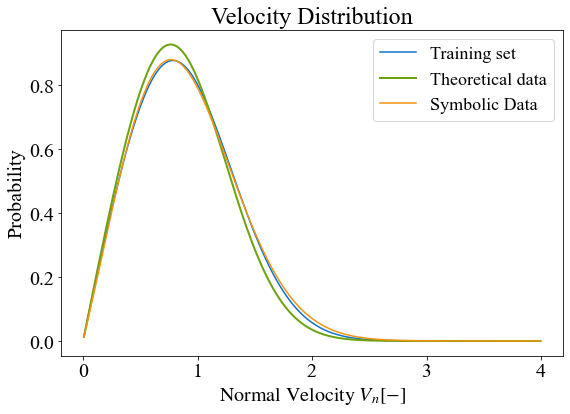

Theoretical SEOE = 0.029
Training SEOE = 0.007


0.955109837631328*x*exp(-(x - 0.0659999999999998)**2)/I0(x + y) + 0.986*x*exp(-(x - 0.0659999999999998)**2)/(I0(0.419)*I0(x - 1.047))

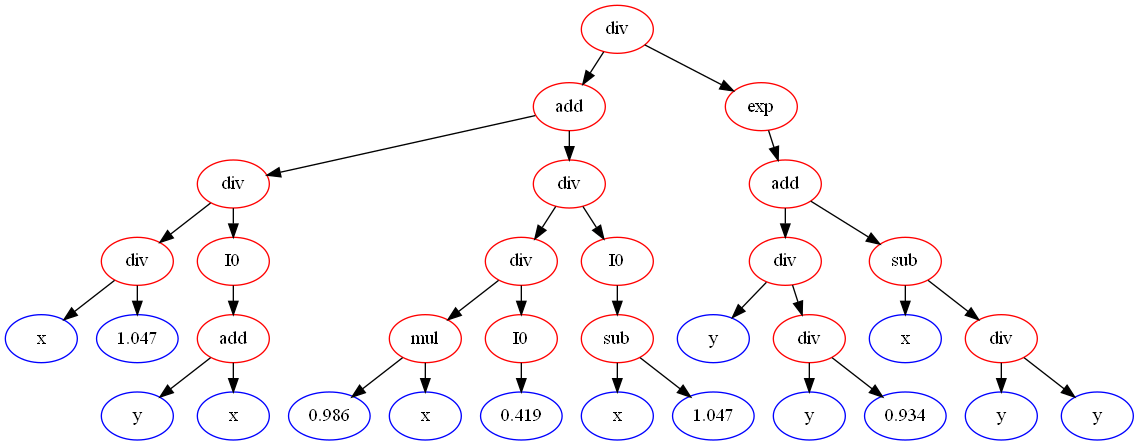

Total Time: 338.237 s


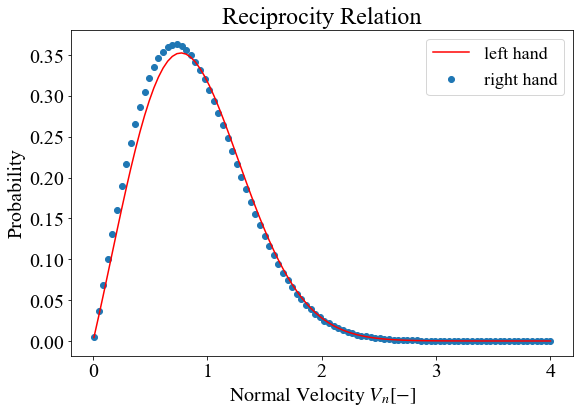

Fitness information: ---------- 
 Error: 0.00044465249814872217 
 P_1: 0.0                  
 P_2: 0.009557720584705498 
 P_3: 0.17315438509400197 


In [26]:
if __name__ == "__main__":
    
    mutation_dic = {'full': 0.05, 'grow': 0.1}
    Data_info = {
        "X_train": X_TRAIN,
        "y_train": y_fit, #PROB_TX,  
        "vincident": VI,
        "theoretical": y_theo,
    }
    fig_path = './DEMP_CL_Normal_Advanced_SR_Vi_09'
    tree_path = "./DEAP_CL_Normal_tree_Advanced_SR_Vi_09.png"


    for num in [0.5, 0.1, 5e-2, 1e-2, 5e-3, 1e-3, 5e-4, 1e-4, 5e-5, 1e-5, 5e-6, 1e-6]:
#         for num in [0.003, 0.002, 0.001, 9e-4, 8e-4, 7e-4]:
        print("{:-^80}".format(num))
        advanceSR_object = AdvancedSR(Data_info=Data_info,
                                          mutation_dic=mutation_dic,
                                          pset=pset,
                                          fig_path=fig_path,
                                          tree_path=tree_path,
                                          gene_size=200, pop_size=10000, 
                                          prob_cx_subtree=0.6,
                                          sk_kind=key,
                                          penalty_list=[1, 0.0, num]) #0.05
        best_tree = advanceSR_object.mainRun()
        advanceSR_object.reciprocityCon(best_tree)
        calculateFitness(best_tree)

## Analysis
    advanceSR_object = AdvancedSR(Data_info=Data_info,
                                      mutation_dic=mutation_dic,
                                      pset=pset,
                                      fig_path=fig_path,
                                      tree_path=tree_path,
                                      gene_size=500, pop_size=5000, 
                                      prob_cx_subtree=0.6,
                                      sk_kind=key,
                                      penalty_list=[1, 0.0, 0.05])

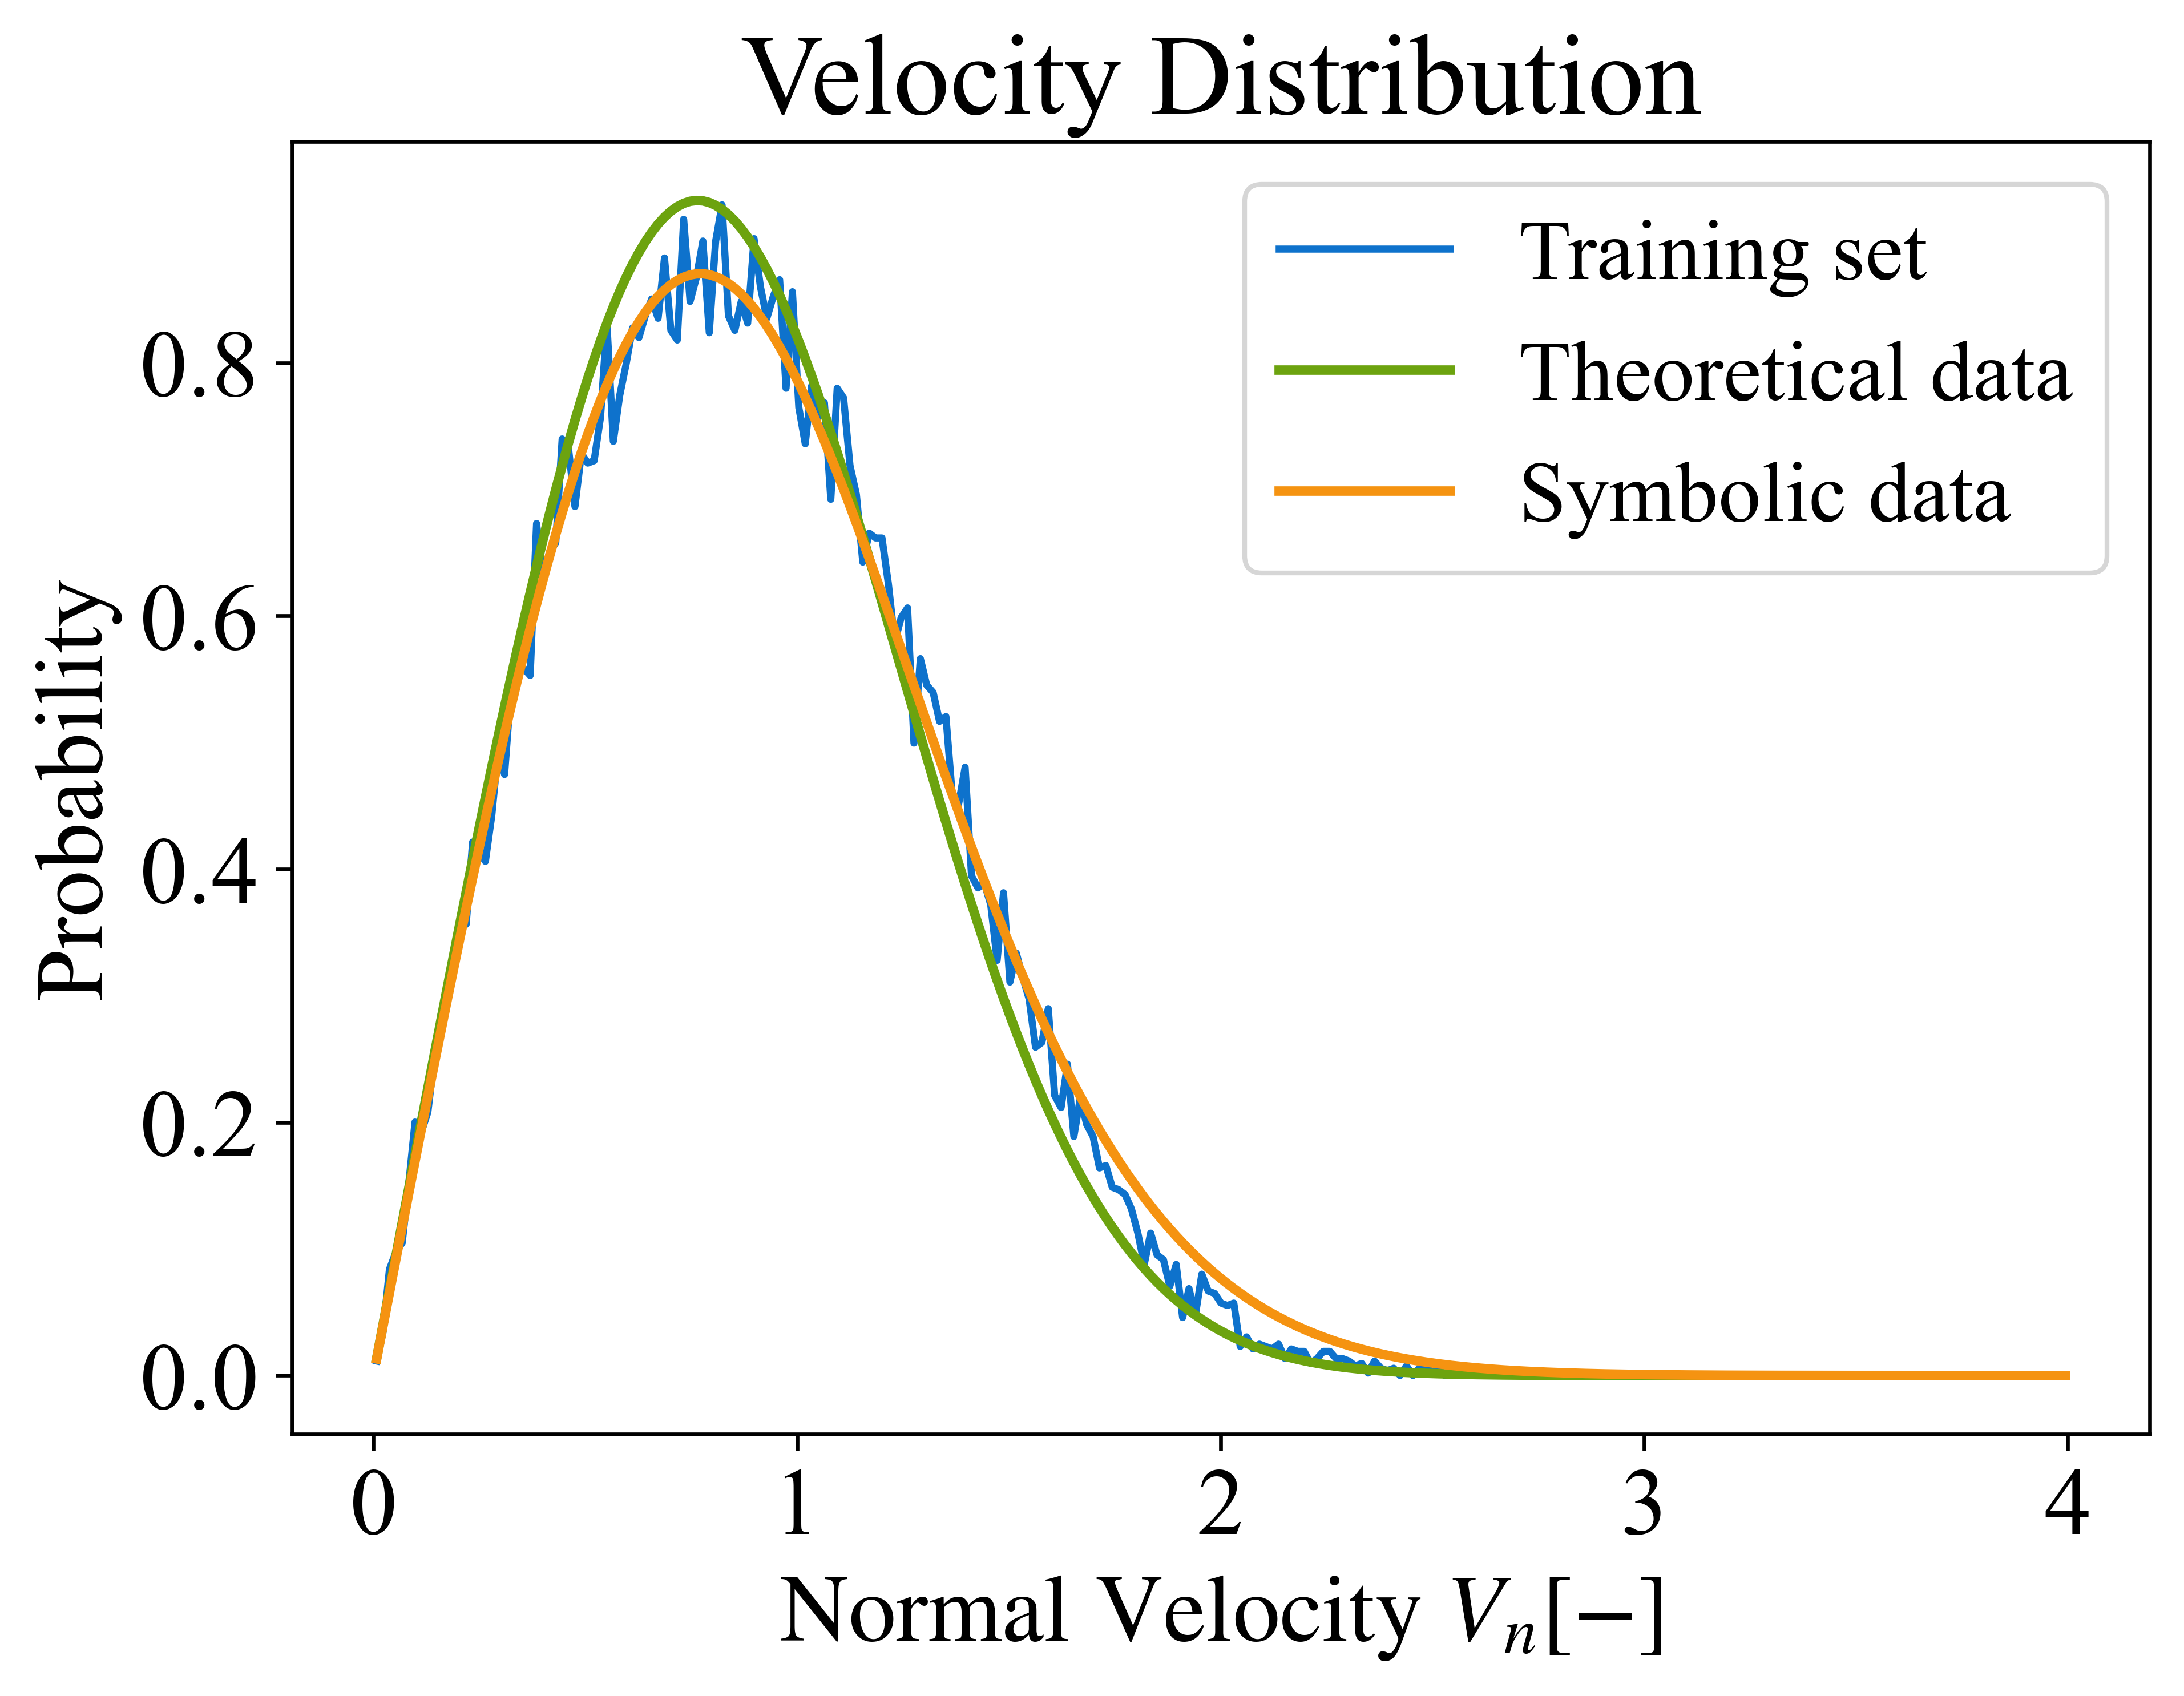

In [24]:
func = gp.compile(str(best_tree), pset)
y_sym = func(X_TRAIN[:, 0], X_TRAIN[:, 1])
fig = plt.figure(figsize=(7, 5), dpi=600)
plt.plot(X_TRAIN[:, 0], Y_TRAIN, label="Training set", c='#0e72cc')
plt.plot(X_TRAIN[:, 0], y_theo, label='Theoretical data', linewidth=2, c='#6ca30f')
plt.plot(X_TRAIN[:, 0], y_sym, label="Symbolic data", linewidth=2, c='#f59311')
if key == "Tangential":
    plt.xlabel("$\mathrm{Tangential\ Velocity}\ V_t [-]$")
elif key == "Normal":
    plt.xlabel("$\mathrm{Normal\ Velocity}\ V_n [-]$")

plt.ylabel("Probability")
plt.title("Velocity Distribution")
plt.legend(fontsize=18)
plt.savefig("./DEAP_CLL_Normal_Vi_09.png", bbox_inches="tight")

plt.show()

In [32]:
np.sqrt(np.sum((Y_TRAIN - y_theo)**2) / (Y_TRAIN.shape[0]-2))

0.03284318632044438

## Cross Validation

In [16]:
def plotCvIndices(cv, X, y, group, ax, n_splits, lw=10):
    """Create a sample plot for indices of a cross-validation object.
    -----------
    cv: It is a cross validation object.
    """
    if X.ndim == 1:
        m, = X.shape  # This should be pay attention when X is 2D
    else:
        m, _ = X.shape

    mask = {'train': {}, 'test': {}}  # Gain the mask after split
    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X=X, y=y, groups=group)):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1  # testing
        indices[tr] = 0  # training
        mask['train'][str(ii + 1) + "_layer"] = tr
        mask['test'][str(ii + 1) + "_layer"] = tt

        # Visualize the results
        ax.scatter(range(len(indices)), [ii + .5] * len(indices),
                   c=indices,
                   marker='_',
                   lw=lw,
                   cmap=cmap_cv,
                   vmin=-.2,
                   vmax=1.2)

    # Formatting
    yticklabels = list(np.arange(n_splits) + 1)
    ax.set(yticks=np.arange(n_splits) + .5,
           yticklabels=yticklabels,
           ylim=[n_splits + 0.2, -.2],
           xlim=[0, m])  # the limit should be set
    ax.set_xlabel(xlabel='Sample index')
    ax.set_ylabel(ylabel="CV iteration")
    ax.tick_params(axis='both', labelsize=18)
    ax.set_title('{}'.format(type(cv).__name__), fontsize=20)

#     plt.savefig('./CrossValidation/CV_Tangential_vi_09.png')

    return ax, mask


def crossValidation(X, Y, n_splits=5):
    """In this class, A is the X, B is the y， A and B are all global variables, 
    should be modified. Here we use X and Y to replace A and B, respectively."""
    if X.ndim == 1:
        n_points, = X.shape
    else:
        n_points, _ = X.shape

    # Plot Sampling Graph
    fig, ax = plt.subplots(figsize=(6.5, 5), dpi=600)
    cv = model_selection.ShuffleSplit(n_splits, test_size=0.2, random_state=0)

    percentiles_classes = [.2, .2, .6]
    y = np.hstack([[ii] * int(n_points * perc)
                   for ii, perc in enumerate(percentiles_classes)])
    groups = np.hstack([[ii] for ii in range(int(n_points))])

    # gain the mask and axes object
    ax, mask = plotCvIndices(cv, X, y, groups, ax=ax, n_splits=n_splits, lw=15)
    ax.legend([Patch(color=cmap_cv(.8)),
               Patch(color=cmap_cv(.1))], ['Testing set', 'Training set'],
              loc=(1.02, .8),
              fontsize=18)
    # Make the legend fit
    plt.tight_layout()
    fig.subplots_adjust(right=1)
    fig.savefig('./CrossValidation/CV_Normal_vi_09.png', bbox_inches='tight')
    plt.show()

    # Extract the train and test data
    return mask["train"], mask["test"]


train_mask, test_mask = crossValidation(X_TX, y_fit_tx)
print("Training set spliting!")

NameError: name 'X_TX' is not defined

In [ ]:
def plotCvIndices(cv, X, y, group, ax, n_splits, lw=10):
    """Create a sample plot for indices of a cross-validation object.
    -----------
    cv: It is a cross validation object.
    """
    if X.ndim == 1:
        m, = X.shape  # This should be pay attention when X is 2D
    else:
        m, _ = X.shape

    mask = {'train': {}, 'test': {}}  # Gain the mask after split
    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X=X, y=y, groups=group)):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1  # testing
        indices[tr] = 0  # training
        mask['train'][str(ii + 1) + "_layer"] = tr
        mask['test'][str(ii + 1) + "_layer"] = tt

        # Visualize the results
        ax.scatter(range(len(indices)), [ii + .5] * len(indices),
                   c=indices,
                   marker='_',
                   lw=lw,
                   cmap=cmap_cv,
                   vmin=-.2,
                   vmax=1.2)

    # Formatting
    yticklabels = list(np.arange(n_splits) + 1)
    ax.set(yticks=np.arange(n_splits) + .5,
           yticklabels=yticklabels,
           ylim=[n_splits + 0.2, -.2],
           xlim=[0, m])  # the limit should be set
    ax.set_xlabel(xlabel='Sample index')
    ax.set_ylabel(ylabel="CV iteration")
    ax.tick_params(axis='both', labelsize=18)
    ax.set_title('{}'.format(type(cv).__name__), fontsize=20)

    plt.savefig('./CrossValidation/CV_Tangential_vi_09.png', bbox_inches='tight')

    return ax, mask


def crossValidation(X, Y, n_splits=5):
    """In this class, A is the X, B is the y， A and B are all global variables, 
    should be modified. Here we use X and Y to replace A and B, respectively."""
    if X.ndim == 1:
        n_points, = X.shape
    else:
        n_points, _ = X.shape

    # Plot Sampling Graph
    fig, ax = plt.subplots(figsize=(7, 5), dpi=600)
    cv = model_selection.ShuffleSplit(n_splits, test_size=0.2, random_state=0)

    percentiles_classes = [.2, .2, .6]
    y = np.hstack([[ii] * int(n_points * perc)
                   for ii, perc in enumerate(percentiles_classes)])
    groups = np.hstack([[ii] for ii in range(int(n_points))])

    # gain the mask and axes object
    ax, mask = plotCvIndices(cv, X, y, groups, ax=ax, n_splits=n_splits, lw=15)
    ax.legend([Patch(color=cmap_cv(.8)),
               Patch(color=cmap_cv(.02))], ['Testing set', 'Training set'],
              loc=(1.02, .8),
              fontsize=16)
    # Make the legend fit
    plt.tight_layout()
    fig.subplots_adjust(right=1)

    # Extract the train and test data
    return mask["train"], mask["test"]


train_mask, test_mask = crossValidation(X_TX, y_fit_tx)
print("Training set spliting!")


for key, train_index, in train_mask.items():
    print("{:-^80}".format(key))
    test_index = test_mask[key]
    train_set_X, train_set_y = X_TX[train_index], y_fit_tx[train_index]
    test_set_X, test_set_y = X_TX[test_index], y_fit_tx[test_index]

    # Sort the data along x direction
    sort_mask = np.argsort(train_set_X)
    train_set_X = train_set_X[sort_mask]
    train_set_y = train_set_y[sort_mask]

    #     VI_TX = vincident[CHO_NUM_TX]
    #     vi_list_normal = np.array([VI_TX for i in range(len(train_set_X))])
    #     train_set_X = np.vstack((train_set_X, -vi_list_normal)).T

    Data_info = {
        "X_train": train_set_X,
        "y_train": train_set_y,
        "vincident": VI_TX,
        "theoretical": y_theo_tx,
    }

    fig_path = "./CrossValidation/DEAP_CV_Tangential_" + str(key) + ".png"
    tree_path = "./CrossValidation/DEAP_CV_Tangential_" + str(key) + ".png"
    advanceSR_object_tx = AdvancedSR(Data_info=Data_info_tx,
                                         mutation_dic=mutation_dic_tx,
                                         pset=pset,
                                         fig_path=fig_path_tx,
                                         tree_path=tree_path_tx,
                                         gene_size=100,
                                         pop_size=5000,
                                         prob_cx_subtree=0.6,
                                         sk_kind="Tangential",
                                         penalty_list=[10, 0.00, 0.001])
    best_tree_tx = advanceSR_object_tx.mainRun()
    advanceSR_object_tx.reciprocityCon(best_tree_tx)
    
# Run cross validation process
# crossValidation(A, B)
# A.shape

In [ ]:
func = gp.compile(best_tree, pset)
cv_x = np.linspace(-4, 4, num=400, endpoint=True)
cv_vi = -np.array([VI_TX for _ in range(cv_x.shape[0])])
cv_x = np.vstack((cv_x, cv_vi)).T
cv_y = func(cv_x[:, 0], cv_x[:, 1])
plt.figure(figsize=(12, 5), dpi=600)
plt.plot(X_TX[:, 0], PROB_TX, label="Training set", linewidth=1.5, c="#334f65")
# plt.plot(X_TX[:, 0], y_fit_tx, label="Theoretical data", linewidth=1.5, c="#05f8d6")
plt.plot(cv_x[:, 0], cv_y, label="Iteration 1", linewidth=2, c='#0e72cc')
plt.plot(cv_x[:, 0], cv_y, label="Iteration 2", linewidth=2, c='#6ca30f')
plt.plot(cv_x[:, 0], cv_y, label="Iteration 3", linewidth=2, c='#f59311')
plt.plot(cv_x[:, 0], cv_y, label="Iteration 4", linewidth=2, c='#fa4343')
plt.plot(cv_x[:, 0], cv_y, label="Iteration 5", linewidth=2, c='#d12a6a')
plt.xlabel("$\mathrm{Tangential\ Velocity}\ V_t [-]$")
plt.ylabel("Probability")
plt.title("Velocity Distribution")
plt.legend(fontsize=18)
plt.savefig("./CrossValidation/CV_Iteration_plot_vi_09.png", bbox_inches="tight")
plt.show()

In [ ]:
plt.figure(figsize=(5, 4), dpi=600)
ite_list = [i for i in range(1, 6)]
score_list = [0.0235, 0.0245, 0.024, 0.0235, 0.0245]
# plt.plot(X_TX[:, 0], PROB_TX, label="Training set", linewidth=1.5, c="#334f65")
plt.plot(ite_list, score_list, linewidth=1, c='#0e72cc', linestyle="-.")
plt.scatter(ite_list, score_list, marker="x", c="#d12a6a")
plt.yticks([0.02, 0.0225, 0.025, 0.0275, 0.03])
plt.xticks([1, 2, 3, 4, 5])
plt.xlabel("$\mathrm{Iteration\ Index}$")
plt.ylabel("SEOE score")
plt.title("SEOE Score")
# plt.legend(fontsize=18)
plt.savefig("./CrossValidation/CV_SEOE_vi_09.png", bbox_inches='tight')
plt.show()